In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import mahotas.features

import itertools
import math
from typing import Tuple, List
from PIL import Image
import os
from scipy.interpolate import interp1d
#from fnmatch import fnmatch
from scipy.signal import convolve

In [2]:



def daugman(gray_img: np.ndarray, center: Tuple[int, int],
            start_r: int, end_r: int, step: int = 1) -> Tuple[float, int]:
    """ The function will calculate pixel intensities for the circles
        in the ``range(start_r, end_r, step)`` for a given ``center``,
        and find a circle that precedes the biggest intensity drop
        :param gray_img: grayscale picture
        :param center:  center coordinates ``(x, y)``
        :param start_r: bottom value for iris radius in pixels
        :param end_r: top value for iris radius in pixels
        :param step: step value for iris radii range in pixels
        .. attention::
            Input grayscale image should be a square, not a rectangle
        :return: intensity_value, radius
    """
    x, y = center
    intensities = []
    mask = np.zeros_like(gray_img)

    # for every radius in range
    radii = list(range(start_r, end_r, step))  # type: List[int]
    for r in radii:
        # draw circle on mask
        cv2.circle(mask, center, r, 255, 1)
        # get pixel from original image, it is faster than np or cv2
        diff = gray_img & mask
        # normalize, np.add.reduce faster than .sum()
        #            diff[diff > 0] faster than .flatten()
        intensities.append(np.add.reduce(diff[diff > 0]) / (2 * math.pi * r))
        # refresh mask
        mask.fill(0)

    # calculate delta of radius intensitiveness
    #     mypy does not tolerate var type reload
    intensities_np = np.array(intensities, dtype=np.float32)
    del intensities

    # circles intensity differences, x5 faster than np.diff()
    intensities_np = intensities_np[:-1] - intensities_np[1:]
    # aply gaussian filter
    #     GaussianBlur() faster than filter2D() with custom kernel
    # original kernel:
    # > The Gaussian filter in our case is designedin MATLAB and
    # > is a 1 by 5 (rows by columns) vector with intensity values
    # > given by vector A = [0.0003 0.1065 0.7866 0.1065 0.0003]
    intensities_np = abs(cv2.GaussianBlur(intensities_np, (1, 5), 0))
    # get maximum value
    idx = np.argmax(intensities_np)  # type: int

    # return intensity value, radius
    return intensities_np[idx], radii[idx]


def find_iris(gray: np.ndarray, *,
              daugman_start: int, daugman_end: int,
              daugman_step: int = 1, points_step: int = 1,) -> Tuple[Tuple[int, int], int]:
    """ The function will apply :func:`daugman` on every pixel in the calculated image slice.
        Basically, we are calculating where lies set of valid circle centers.
        It is assumed that iris center lies within central 1/3 of the image.
        :param gray: graysacale **square** image
        :param points_step: it will run daugman for each ``points_step``th point.
                            It has linear correlation with overall iris search speed
        :param daugman_start: bottom value for iris radius in pixels for :func:``daugman``
        :param daugman_end: top value for iris radius in pixels for :func:``daugman``
        :param daugman_step: step value for iris radii range in pixels for :func:``daugman``.
                             It has linear correlation with overall iris search speed
        :return: radius with biggest intensiveness delta on image as ``((xc, yc), radius)``
    """
    h, w = gray.shape
    if h != w:
        print('Your image is not a square!')
    print("yes")
    # reduce step for better accuracy
    # we will look only on dots within central 1/3 of image
    single_axis_range = range(int(h / 3), h - int(h / 3), points_step)
    all_points = itertools.product(single_axis_range, single_axis_range)

    intensity_values = []
    coords = []  # List[Tuple[Tuple(int, int), int]]

    for point in all_points:
        val, r = daugman(gray, point, daugman_start, daugman_end, daugman_step)
        intensity_values.append(val)
        coords.append((point, r))

    # return the radius with biggest intensiveness delta on image
    # ((xc, yc), radius)
    # x10 faster than coords[np.argmax(values)]
    best_idx = intensity_values.index(max(intensity_values))
    return coords[best_idx]

In [4]:
# rechange i n code

_round = lambda x: np.round(x).astype(np.uint8)
print("dvnkdsjvs")

root = 'D:\\5505'
pattern = ".JPG"
tup_cord = ()
i=0
x_train_masked_nor = []
x_train_masked_zernik = []
folder_li = []
x_train_cart = []
x_train_iris_norm= []
x_train_cart_zernike = []
for path, subdirs, files in os.walk(root):
    files1=0
    for name in files:
        
        print(name)
        
        # if fnmatch(name, pattern):
        print(os.path.join(path, name))
        img = os.path.join(path, name)
        files1=files1+1
        i=i+1
        print(i)
   
#         src = cv2.imread(img, cv2.IMREAD_COLOR)
#         print(src.shape)
        image = Image.open(img)
        print(image)
        color_coverted = cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2GRAY)
        
#         plt.imshow(color_coverted)
#         cv2.waitKey(5000)
#         cv2.destroyAllWindows()
        new_size = (200, 200) 
        res = cv2.resize(np.asarray(image), new_size)
        resize_img = cv2.resize(color_coverted, new_size)
        
#         cv2.imshow('resize', resize_img)
#         cv2.waitKey(10000)
#         cv2.destroyAllWindows()
        # plt.imshow(resize_img)
        gray_img = resize_img
        Image.fromarray(resize_img).save("resize.jpg")
        # gray_img = cv2.cvtColor(resize_img, cv2.COLOR_RGB2GRAY)
        #plt.imshow(gray_img)
        answer = find_iris(gray_img, daugman_start=10, daugman_end=30, daugman_step=1, points_step=1)
        print(answer)
        
        iris_center, iris_rad = answer
        out = gray_img.copy()
        
        
        
        sigma = 0.5
        maxRadius = np.zeros(out.shape)
        maxBlur = np.zeros(out.shape)
        x,y,rmin,rmax = iris_center[0], iris_center[1], 0, iris_rad
        for i in np.arange(int(x) - 5, int(x) + 5):
            for j in np.arange(int(y) - 5, int(y) + 5):
                max_blur, max_blur_radius, blur = partialDerivative(out, [i, j], rmin, rmax, sigma, 600, 'iris')
                maxRadius[i, j] = max_blur_radius
                maxBlur[i, j] = max_blur
                
        X, Y = np.where(maxBlur == maxBlur.max())
        radius = maxRadius[X, Y]
        
        coordPupil = np.array([X, Y, radius])
        print("coord pupil", coordPupil,  radius)
        
        ############
        
#         sigma = 0.5
#         maxRadius = np.zeros(out.shape)
#         maxBlur = np.zeros(out.shape)
#         x,y,rmin,rmax = int(coordPupil[0][0])+1, int(coordPupil[1][0]), 0, iris_rad
#         for i in np.arange(int(x) - 5, int(x) + 5):
#             for j in np.arange(int(y) - 5, int(y) + 5):
#                 max_blur, max_blur_radius, blur = partialDerivative(out, [i, j], rmin, rmax, sigma, 600, 'pupil')
#                 maxRadius[i, j] = max_blur_radius
#                 maxBlur[i, j] = max_blur
#         X, Y = np.where(maxBlur == maxBlur.max())
#         radius = maxRadius[X, Y]
        
#         coordPupil = np.array([X, Y, radius])
#         print("coord pupil", coordPupil,  radius)
        
        
        #################
        # = cv2.circle(blank, (int(coordPupil[0]), int(coordPupil[1])), int(radius), 255, -1)
    
        
        
        iris_img = cv2.circle(res, iris_center, iris_rad, (255, 0, 0), 1)
        #iris_img = cv2.circle(res, (int(coordPupil[0][0]), int(coordPupil[1])), int(10), (255, 0, 0), 1)
        # iris_img = cv2.circle(out, iris_center, iris_rad,coord (0, 0, 255), 1)
        _ = plt.imshow(res[::,::])
#         plt.scatter(99, 99, 50, c="r", marker="+")
        plt.scatter(int(coordPupil[0][0]), int(coordPupil[1][0]), 30, c="r", marker="+") # plot markers
        plt.show()
        blank = np.zeros(out.shape[:2], dtype='uint8')
        
        center_coordinates = iris_center
        
        radius = iris_rad
        
        mask = cv2.circle(blank, center_coordinates, radius, 255, -1)
        
        masked = cv2.bitwise_and(out, out, mask=mask)
        
        #
        
        
        #
        x=iris_center[0]
        y=iris_center[1]
        print(x,y)
        r = iris_rad
        r=r
        print("rad", r)
        iris_image1 = resize_img[y-r:y+r,x-r:x+r]
        #
        
#         answer = find_iris(iris_image1, daugman_start=10, daugman_end=30, daugman_step=1, points_step=2)
#         print(answer)
#         iris_img11 = cv2.circle(iris_image1, (11,11), 13, (255, 0, 0), 1)
#         plt.imshow(iris_img11)
        #
        Image.fromarray(iris_image1).save("ey.jpg")
        iris_image_to_show1 = cv2.resize(iris_image1, (iris_image1.shape[1]*2, iris_image1.shape[0]*2))
        print(iris_image_to_show1.shape)
        # plt.imshow(iris_image_to_show1)
                 #theta
        
        iris_image_to_show = iris_image_to_show1
        Image.fromarray(iris_image_to_show1).save('iriss.jpeg')
        #masked1
        q = np.arange(0.00, np.pi*2, 0.01)
        # masked  #cv2.imread("maskimg.jpg", cv2.IMREAD_UNCHANGED)
        print(iris_image_to_show.shape)
        inn = np.arange(0, int(iris_image_to_show.shape[0]/2), 1) #radius
        print(inn.size)
        cartisian_image = np.empty(shape = [inn.size, int(iris_image_to_show.shape[1]), 3])
        
        m = interp1d([np.pi*2, 0],[0,iris_image_to_show.shape[1]])
        li_x = []
        li_y = []
        for r in inn:
            
            for t in q:
                polarX = int((r * np.cos(t)) + iris_image_to_show.shape[1]/2)
                
                polarY = int((r * np.sin(t)) + iris_image_to_show.shape[0]/2)
                #print(polarX,polarY )
                if polarX  not in li_x:
                    li_x.append(polarX)
                if polarY not in li_y:
                    li_y.append(polarY)
               # plt.scatter(polarX, polarY, 20, c="b", marker="+")
                
#                 tup_cord + (polarX,polarY )
                
                cartisian_image[r][int(m(t) - 1)] = iris_image_to_show[polarY][polarX]

             
        cc = cartisian_image
        im = Image.fromarray(iris_image_to_show)
        
        cartisian_image = cartisian_image.astype('uint8')
        
        im = Image.fromarray(cartisian_image)
#         plt.imshow(im)
#         plt.show()
        
        #plt.imshow(iris_image_to_show1)
        # im.save('eye288.jpeg')
#         cv2.imshow('Output', cartisian_image)
#         cv2.waitKey(5000)
#         cv2.destroyAllWindows()
        
#         img_normalized = cv2.normalize(masked, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
# #         x_train.append(img_normalized)
        
#         zer_mom_norm = mahotas.features.zernike_moments(masked, 10)
        
#         x_train_masked_zernik.append(zer_mom_norm)
#         x_train_masked_nor.append(img_normalized)
#         x_train_cart.append(np.array(im))
        

dvnkdsjvs
R2.JPG
D:\5505\R2.JPG
1
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=5184x3456 at 0x267CC8359A0>
yes
((98, 102), 15)


NameError: name 'partialDerivative' is not defined

(60, 60)
yes
((31, 32), 9)


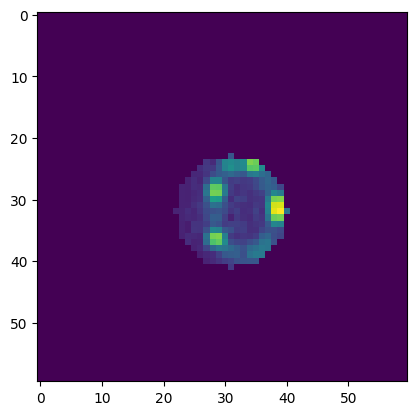

In [4]:
image = Image.open("iriss.jpeg")
#imgg = cv2.resize(image, (image.size[1]*2, image.size[0]*2))
print(np.asarray(image).shape)
answer = find_iris(np.asarray(image), daugman_start=9, daugman_end=30, daugman_step=1, points_step=1)
print(answer)
plt.imshow(np.asarray(image))
# print(gray_img.shape)
blank = np.zeros(np.asarray(image).shape[:2], dtype='uint8')
mask2 = cv2.circle(blank, answer[0], answer[1], 255, -1)
        
masked = cv2.bitwise_and(np.asarray(image), np.asarray(image), mask=mask2)
plt.imshow(np.asarray(masked))

In [5]:
# # re = cv2.imread()
for i in range(iris_image_to_show1.shape[0]):
    for j in range(iris_image_to_show1.shape[0]):
        if (i-answer[0][0])**2+(j-answer[0][1])**2-answer[1]**2<0:
            iris_image_to_show1[i][j] = 0

plt.imshow(iris_image_to_show1)
answer = find_iris(np.asarray(iris_image_to_show1), daugman_start=9, daugman_end=30, daugman_step=1, points_step=1)
print(answer)

NameError: name 'iris_image_to_show1' is not defined

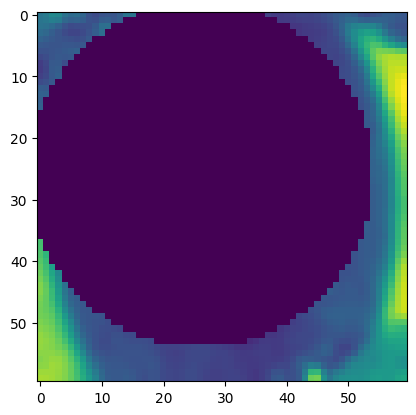

In [50]:
blank = np.zeros(np.asarray(iris_image_to_show1).shape[:2], dtype='uint8')
mask2 = cv2.circle(blank, answer[0], answer[1], 255, -1)
        
masked = cv2.bitwise_and(np.asarray(iris_image_to_show1), np.asarray(iris_image_to_show1), mask=mask2)
plt.imshow(np.asarray(masked))
for i in range(iris_image_to_show1.shape[0]):
    for j in range(iris_image_to_show1.shape[0]):
        if (i-answer[0][0])**2+(j-answer[0][1])**2-answer[1]**2<0:
            iris_image_to_show1[i][j] = 0

plt.imshow(iris_image_to_show1)

In [16]:
answer = find_iris(gray_img, daugman_start=8, daugman_end=5, daugman_step=1, points_step=1)
print(answer)

yes


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\smooth.dispatch.cpp:617: error: (-215:Assertion failed) !_src.empty() in function 'cv::GaussianBlur'


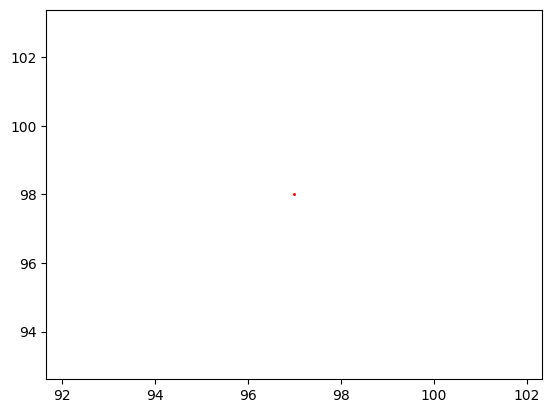

In [25]:
plt.scatter(97, 98, marker=".", color="red", s=5)

15
98 98
97 98
96 98
95 98
95 98
94 99
93 99
93 99
92 99
91 99
91 100
90 100
89 100
88 100
88 100
87 101
86 101
86 101
85 101
84 101
97 98
97 98
96 98
95 98
95 98
94 98
93 98
93 98
92 99
91 99
91 99
90 99
89 99
88 99
88 99
87 99
86 99
86 100
85 100
84 100
97 98
97 98
96 98
95 98
95 98
94 98
93 98
93 98
92 98
91 98
91 98
90 98
89 98
89 98
88 98
87 98
87 98
86 98
85 98
85 98
97 98
97 98
96 98
95 98
95 98
94 98
93 98
93 97
92 97
92 97
91 97
90 97
90 97
89 97
88 97
88 97
87 97
86 97
86 97
85 97
97 98
97 98
96 98
96 98
95 97
94 97
94 97
93 97
92 97
92 97
91 97
90 97
90 96
89 96
89 96
88 96
87 96
87 96
86 96
85 96
97 98
97 98
96 98
96 97
95 97
94 97
94 97
93 97
93 96
92 96
91 96
91 96
90 96
90 95
89 95
88 95
88 95
87 95
87 94
86 94
97 98
97 98
96 98
96 97
95 97
95 97
94 96
93 96
93 96
92 96
92 95
91 95
91 95
90 95
90 94
89 94
89 94
88 93
87 93
87 93
97 98
97 98
96 97
96 97
95 97
95 96
94 96
94 96
93 95
93 95
92 95
92 94
91 94
91 94
90 93
90 93
89 93
89 92
88 92
88 92
97 98
97 98
96 97
96 97


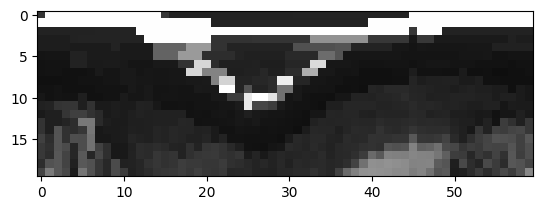

In [663]:

l2= []
l3 = []
def daugman_normalizaiton(image, height, width, r_in, r_out):       # Daugman归一化，输入为640*480,输出为width*height
    thetas = np.arange(0, 2 * np.pi, 2 * np.pi / width)  # Theta values
    r_out = r_in + r_out
    print(r_out)
    # Create empty flatten image
    flat = np.zeros((height,width, 3), np.uint8)
    circle_x = 99#int(image.shape[0] / 2)
    circle_y = 102#int(image.shape[1] / 2)

    for i in range(width):
        for j in range(height):
            theta = thetas[i]  # value of theta coordinate
            r_pro = j / height  # value of r coordinate(normalized)
           # print(r_pro)
            l1 =[]
            # get coordinate of boundaries
            Xi = 97 + r_in * np.cos(theta)
            Yi = 98 + r_in * np.sin(theta)
            Xo = circle_x - r_out * np.cos(theta)
            Yo = circle_y - r_out * np.sin(theta)
           
            # the matched cartesian coordinates for the polar coordinates
            Xc = (1 - r_pro) * Xi + r_pro * Xo
            Yc = (1 - r_pro) * Yi + r_pro * Yo
            l1.append(int(Xo))
            l1.append(int(Yo))
            l2.append(l1)
            color = image[int(Xc)][int(Yc)]  # color of the pixel
            print(int(Xc), int(Yc))
            
            flat[j][i] = color
#             plt.scatter(Xi, Yi, 30, c="r", marker="+")
    return flat, Xi, Yi, Xo, Yo, l2
image_nor, x,y,z,k, li =  daugman_normalizaiton(gray_img,20, 60, 1, 14)

# print(li)
plt.imshow(image_nor)

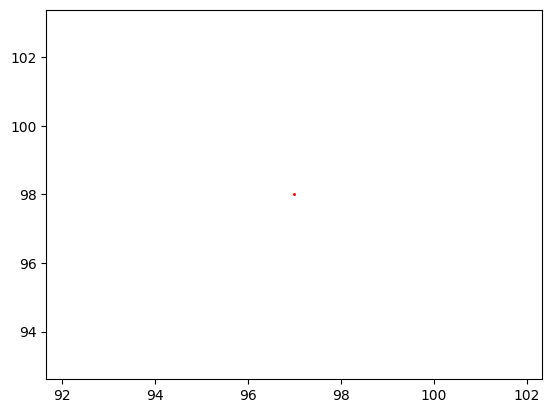

In [24]:

# pts = np.array(li)

# plt.imshow(gray_img)
plt.scatter(97, 98, marker=".", color="red", s=5) # og:shorthand for green circle
# plt.scatter(pts[:, 0], pts[:, 1], marker=".", color="red", s=5)
# plt.show()

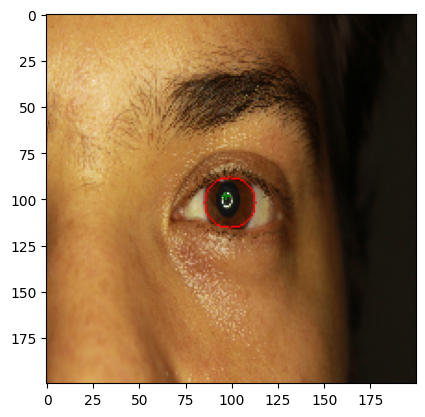

In [626]:
#iris_img = cv2.circle(res, (int(coordPupil[0][0]), int(coordPupil[1][0])), 3, (255, 0, 0), 1)
_ = plt.imshow(res[::,::])

plt.scatter(int(coordPupil[0][0]), int(coordPupil[1][0]), 30, c="g", marker="+")
# plot markers
plt.show()

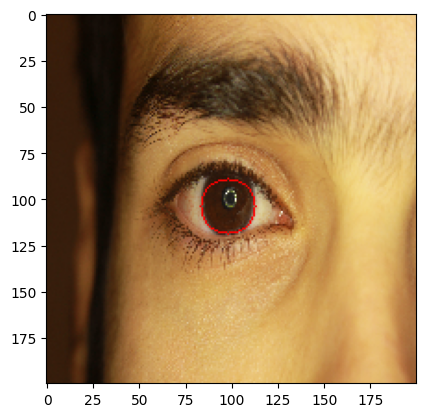

In [449]:
plt.imshow(iris_img)

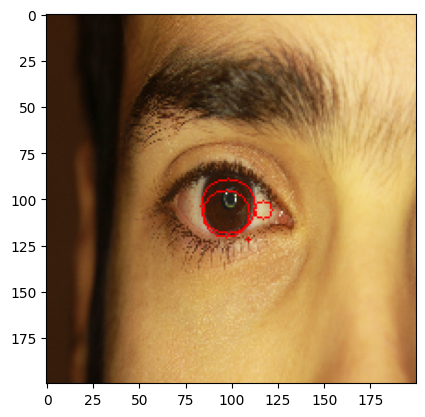

In [444]:
answer
iris_img = cv2.circle(res, ((99, 99)), 13, (255, 0, 0), 1)
        #iris_img = cv2.circle(res, (int(coordPupil[0]), int(coordPupil[1])), int(radius), (0, 0, 255), 1)
        # iris_img = cv2.circle(out, iris_center, iris_rad,coord (0, 0, 255), 1)
_ = plt.imshow(res[::,::])



In [453]:
image_read = cv2.imread("L3.JPG")
output = image_read.copy()
image_test = cv2.imread(path, cv2.COLOR_RGB2GRAY)
image_test = cv2.GaussianBlur(image_test, (7, 7), 1)
#image_test = cv2.Canny(image_test, 20, 70, apertureSize=3)
#image_test = cv2.Laplacian(image_test,cv2.CV_8U)
image_test = cv2.Sobel(image_test,cv2.CV_8U,1,1,ksize=5)
cv2.imshow("Sobel outer", image_test)


hough_circle = cv2.HoughCircles(image_test, cv2.HOUGH_GRADIENT, 1.3, 800)
if hough_circle is not None:
    hough_circle = np.round(hough_circle[0, :]).astype("int")
    for (x, y, radius) in hough_circle:
        cv2.circle(output, (x, y), radius, (255, 0, 0), 4)
		

image_test = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
image_test = cv2.GaussianBlur(image_test, (7, 7), 1)
#image_test = cv2.Canny(image_test, 100, 120, apertureSize=3)
#image_test = cv2.Laplacian(image_test,cv2.CV_8U)
image_test = cv2.Sobel(image_test,cv2.CV_8U,1,0,ksize=5)
cv2.imshow("Sobel-2", image_test)

circles = cv2.HoughCircles(image_test,cv2.HOUGH_GRADIENT,1,800,
                            param1=50,param2=20,minRadius=0,maxRadius=60)
circles = np.round(circles[0, :]).astype("int")

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\smooth.dispatch.cpp:617: error: (-215:Assertion failed) !_src.empty() in function 'cv::GaussianBlur'


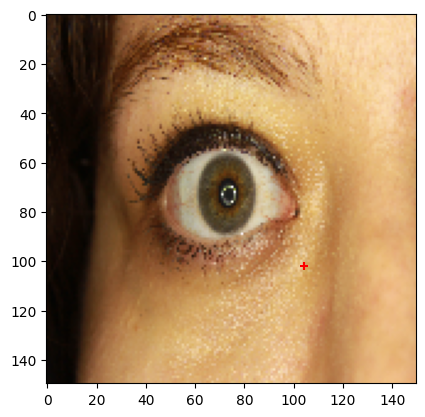

In [475]:
_ = plt.imshow(res[::,::])
plt.scatter(104, 102, 40, c="r", marker="+")
plt.show()
        #plt.scatter(int(coordPupil[0]), int(coordPupil[1]), 50, c="r", marker="+") # plot markers
        #plt.show()

114 100
112 100
110 100
108 100
106 100
104 100
102 100
100 100
98 100
96 100
95 100
93 100
91 100
89 100
87 100
85 100
83 100
81 100
79 100
77 100
113 101
112 101
110 101
108 100
106 100
104 100
102 100
100 100
98 99
96 99
95 99
93 99
91 99
89 98
87 98
85 98
83 98
81 98
79 97
78 97
113 102
111 102
109 102
108 101
106 101
104 100
102 100
100 100
98 99
96 99
95 98
93 98
91 98
89 97
87 97
85 96
83 96
82 96
80 95
78 95
113 104
111 103
109 103
107 102
106 101
104 101
102 100
100 100
98 99
97 99
95 98
93 97
91 97
89 96
88 96
86 95
84 94
82 94
80 93
78 93
112 105
111 104
109 104
107 103
105 102
104 101
102 101
100 100
98 99
97 98
95 97
93 97
91 96
90 95
88 94
86 94
85 93
83 92
81 91
79 91
112 107
110 106
108 105
107 104
105 103
103 102
102 101
100 100
98 99
97 98
95 97
94 96
92 95
90 94
89 93
87 92
85 91
84 90
82 89
80 88
111 108
109 107
108 105
106 104
105 103
103 102
102 101
100 100
99 99
97 98
95 97
94 95
92 94
91 93
89 92
88 91
86 90
85 89
83 88
82 87
110 109
108 108
107 106
106 105
104 

(200, 200)


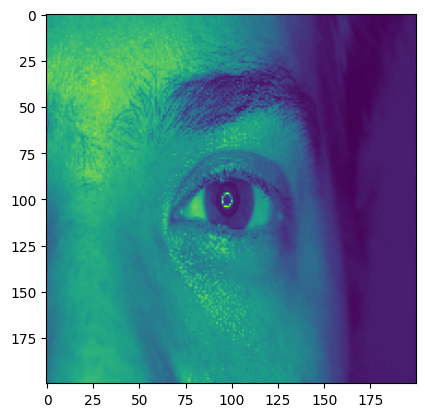

In [602]:
print(gray_img.shape)
plt.imshow(gray_img)



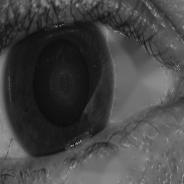

In [456]:
image_r

(3456, 5184, 3)
yes
((119, 115), 10)


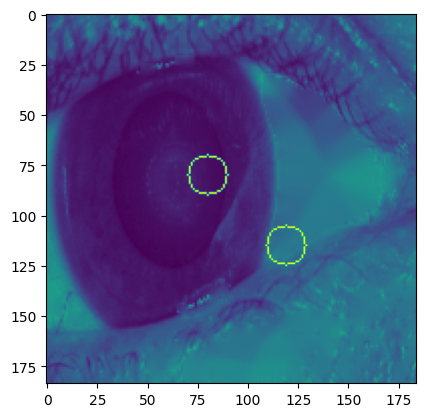

In [477]:
# plt.imshow(out)
src = cv2.imread("L3.JPG", cv2.IMREAD_COLOR)
print(src.shape)
image_r = Image.open("ref.jpg")
#color_coverted = cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2GRAY)

#       plt.imshow(color_coverted)
#       cv2.waitKey(5000)
#       cv2.destroyAllWindows()
new_size = (150, 150) 
res = cv2.resize(np.asarray(image), new_size)
resize_img = cv2.resize(color_coverted, new_size)

#       cv2.imshow('resize', resize_img)
#       cv2.waitKey(10000)
#       cv2.destroyAllWindows()
# plt.imshow(resize_img)
gray_img = res

print(find_iris(out, daugman_start=10, daugman_end=30, daugman_step=1, points_step=2))

iris_img111 = cv2.circle(dst, (119, 115), 10, (255, 0, 0), 1)
plt.imshow(iris_img111)


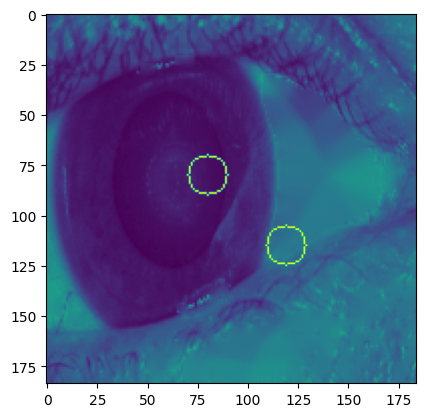

In [476]:
plt.imshow(dst)

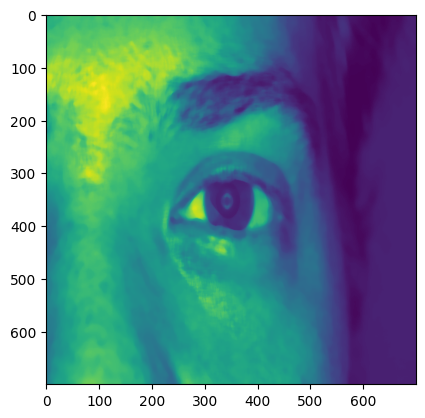

In [12]:

image = cv2.imread("L3.JPG")
# np.asarray(image)
image = cv2.resize(np.asarray(image), (700, 700), interpolation=cv2.INTER_LINEAR)
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gray = cv2.medianBlur(image, 11)
ret, _ = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 50, param1=ret, param2=30, minRadius=10,
                           maxRadius=100)
circles = circles[0, :, :]  # 提取为二维
circles = np.int16(np.around(circles))  # 四舍五入，取整
for i in circles[:]:
    image = image[i[1] - i[2] - r:i[1] + i[2] + r, i[0] - i[2] -r:i[0] + i[2] + r]
    radus = i[2]

ret, mask = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY) # 二值化
kernel = np.ones((5, 5), np.uint8)                          # 构建算子
dilation = cv2.dilate(mask, kernel, iterations=1)           # 构建蒙版
dst = cv2.inpaint(image, dilation, 5, cv2.INPAINT_TELEA)      # FMM算法修复光点
plt.imshow(gray)
im = Image.fromarray(dst)
im.save("ref.jpg")

In [13]:
print(dst.shape)

(202, 202)


yes
((127, 75), 27)


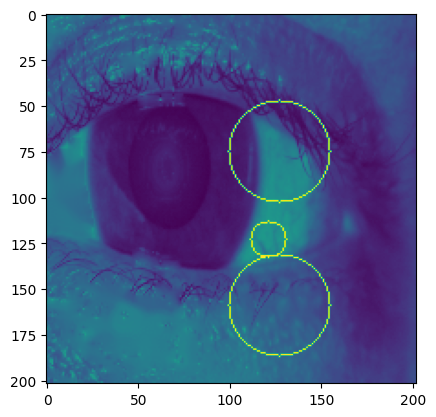

In [17]:
print(find_iris(dst, daugman_start=10, daugman_end=30, daugman_step=1, points_step=2))

iris_img111 = cv2.circle(dst, (121,123), 10, (255, 0, 0), 1)
plt.imshow(iris_img111)


In [300]:
_, thresh = cv2.threshold(im, 100, 255, cv2.THRESH_BINARY)
        # Now find the contours and then find the pupil in the contours.
contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
c = cv2.HoughCircles(contours, cv2.HOUGH_GRADIENT, 2, im.shape[0]/2)

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'threshold'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [6]:
def daugman_normalizaiton(image, height, width, r_in, r_out):       # Daugman归一化，输入为640*480,输出为width*height
    thetas = np.arange(0, 2 * np.pi, 2 * np.pi / width)  # Theta values
    r_out = r_in + r_out
    # Create empty flatten image
    flat = np.zeros((height,width, 3), np.uint8)
    circle_x = int(image.shape[0] / 2)
    circle_y = int(image.shape[1] / 2)

    for i in range(width):
        for j in range(height):
            theta = thetas[i]  # value of theta coordinate
            r_pro = j / height  # value of r coordinate(normalized)

            # get coordinate of boundaries
            Xi = circle_x + r_in * np.cos(theta)
            Yi = circle_y + r_in * np.sin(theta)
            Xo = circle_x + r_out * np.cos(theta)
            Yo = circle_y + r_out * np.sin(theta)

            # the matched cartesian coordinates for the polar coordinates
            Xc = (1 - r_pro) * Xi + r_pro * Xo
            Yc = (1 - r_pro) * Yi + r_pro * Yo

            color = image[int(Xc)][int(Yc)]  # color of the pixel

            flat[j][i] = color
    return flat
r = 55
height = 60
width = 360
image_nor =  daugman_normalizaiton(dst,height, width, radus, r)

plt.imshow(dst)


NameError: name 'dst' is not defined

(150, 150)
yes


C:\Users\kmitt\AppData\Local\Temp\ipykernel_22976\908517515.py:28: RuntimeWarning: divide by zero encountered in divide
  intensities.append(np.add.reduce(diff[diff > 0]) / (2 * math.pi * r))


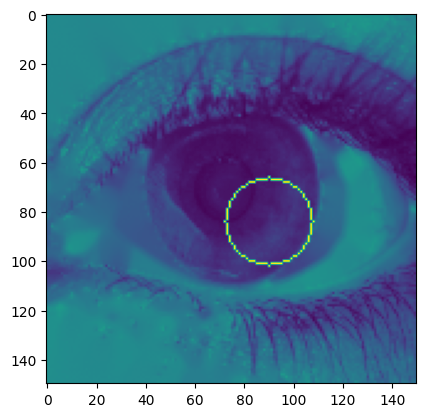

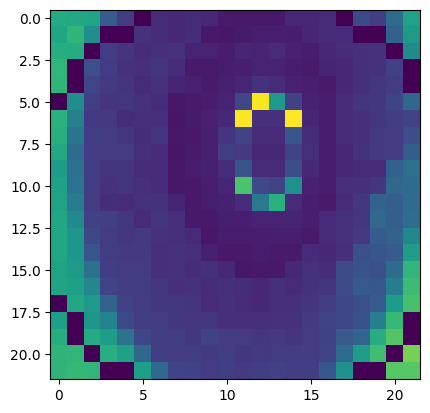

In [182]:
plt.imshow(iris_image1)

In [94]:
cerchi = np.round(cerchi[0,:]).astype("int")
# output = iris_image1.copy()
for (x,y,raggio) in cerchi:
    
    cv2.circle(output, (x,y),raggio,(255,0,0),4)
cv2.imshow("Image test", np.hstack([image_iride,output]))
cv2.waitKey(5000)
cv2.destroyAllWindows()
# plt.imshow(image_)

TypeError: cannot unpack non-iterable numpy.int32 object

In [66]:
np.round(cerchi[0,:]).astype("int")

array([50])

In [30]:
if eye_circles is not None:
    circle = eye_circles[0][0]
    iris_coordinates = (circle[0], circle[1])

if iris_coordinates is not None:
    x = int(iris_coordinates[0])
    y = int(iris_coordinates[1])

    w = int(round(circle[2]) + 10)
    h = int(round(circle[2]) + 10)

    #cv2.circle(original_eye, iris_coordinates, int(circle[2]), (255,0,0), thickness=2)
    iris_image = original_eye[y-h:y+h,x-w:x+w]
    iris_image_to_show = cv2.resize(iris_image, (iris_image.shape[1]*2, iris_image.shape[0]*2))

q = np.arange(0.00, np.pi*2, 0.01) #theta
inn = np.arange(0, int(iris_image_to_show.shape[0]/2), 1) #radius

cartisian_image = np.empty(shape = [inn.size, int(iris_image_to_show.shape[1]), 3])
m = interp1d([np.pi*2, 0],[0,iris_image_to_show.shape[1]])

for r in inn:
    for t in q:
        polarX = int((r * np.cos(t)) + iris_image_to_show.shape[1]/2)
        polarY = int((r * np.sin(t)) + iris_image_to_show.shape[0]/2)
        cartisian_image[r][int(m(t) - 1)] = iris_image_to_show[polarY][polarX]

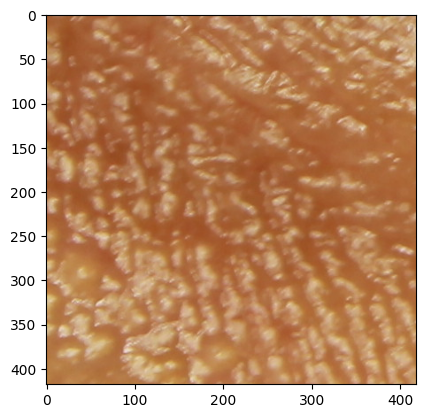

In [33]:
plt.imshow(iris_image)

In [4]:
# iris_center[0]\
# from scipy.signal import convolve
# k = partialDerivative(gray_img, [i, j], rmin, rmax, sigma, 600, 'pupil')
# k

def normalize(image, x_iris, y_iris, r_iris, x_pupil, y_pupil, r_pupil,
			  radpixels, angulardiv):
	"""
	Description:
		Normalize iris region by unwraping the circular region into a rectangular
		block of constant dimensions.
	Input:
		image		- Input iris image.
		x_iris		- x-coordinate of the circle defining the iris boundary.
		y_iris		- y-coordinate of the circle defining the iris boundary.
		r_iris		- Radius of the circle defining the iris boundary.
		x_pupil		- x-coordinate of the circle defining the pupil boundary.
		y_pupil		- y-coordinate of the circle defining the pupil boundary.
		r_pupil		- Radius of the circle defining the pupil boundary.
		radpixels	- Radial resolution (vertical dimension).
		angulardiv	- Angular resolution (horizontal dimension).
	Output:
		polar_array	- Normalized form of the iris region.
		polar_noise	- Normalized form of the noise region.
	"""
	radiuspixels = radpixels + 2
	angledivisions = angulardiv-1

	r = np.arange(radiuspixels)
	theta = np.linspace(0, 2*np.pi, angledivisions+1)

	# Calculate displacement of pupil center from the iris center
	ox = x_pupil - x_iris
	oy = y_pupil - y_iris

	if ox <= 0:
		sgn = -1
	elif ox > 0:
		sgn = 1

	if ox==0 and oy > 0:
		sgn = 1

	a = np.ones(angledivisions+1) * (ox**2 + oy**2)

	# Need to do something for ox = 0
	if ox == 0:
		phi = np.pi/2
	else:
		phi = np.arctan(oy/ox)

	b = sgn * np.cos(np.pi - phi - theta)

	# Calculate radius around the iris as a function of the angle
	r = np.sqrt(a)*b + np.sqrt(a*b**2 - (a - r_iris**2))
	r = np.array([r - r_pupil])

	rmat = np.dot(np.ones([radiuspixels,1]), r)

	rmat = rmat * np.dot(np.ones([angledivisions+1,1]),
							np.array([np.linspace(0,1,radiuspixels)])).transpose()
	rmat = rmat + r_pupil

	# Exclude values at the boundary of the pupil iris border, and the iris scelra border
	# as these may not correspond to areas in the iris region and will introduce noise.
	# ie don't take the outside rings as iris data.
	rmat = rmat[1 : radiuspixels-1, :]

	# Calculate cartesian location of each data point around the circular iris region
	xcosmat = np.dot(np.ones([radiuspixels-2,1]), np.array([np.cos(theta)]))
	xsinmat = np.dot(np.ones([radiuspixels-2,1]), np.array([np.sin(theta)]))

	xo = rmat * xcosmat
	yo = rmat * xsinmat

	xo = x_pupil + xo
	xo = np.round(xo).astype(int)
	coords = np.where(xo >= image.shape[1])
	xo[coords] = image.shape[1] - 1
	coords = np.where(xo < 0)
	xo[coords] = 0
	
	yo = y_pupil - yo
	yo = np.round(yo).astype(int)
	coords = np.where(yo >= image.shape[0])
	yo[coords] = image.shape[0] - 1
	coords = np.where(yo < 0)
	yo[coords] = 0

	# Extract intensity values into the normalised polar representation through
	# interpolation
	# x,y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
	# f = interpolate.interp2d(x, y, image, kind='linear')
	# polar_array = f(xo, yo)
	# polar_array = polar_array / 255

	polar_array = image[yo, xo]
	polar_array = polar_array / 255

	# Create noise array with location of NaNs in polar_array
	polar_noise = np.zeros(polar_array.shape)
	coords = np.where(np.isnan(polar_array))
	polar_noise[coords] = 1

	# Get rid of outling points in order to write out the circular pattern
	image[yo, xo] = 255

	# Get pixel coords for circle around iris
	x,y = circlecoords([x_iris,y_iris], r_iris, image.shape)
	image[y,x] = 255

	# Get pixel coords for circle around pupil
	xp,yp = circlecoords([x_pupil,y_pupil], r_pupil, image.shape)
	image[yp,xp] = 255

	# Replace NaNs before performing feature encoding
	coords = np.where((np.isnan(polar_array)))
	polar_array2 = polar_array
	polar_array2[coords] = 0.5
	avg = np.sum(polar_array2) / (polar_array.shape[0] * polar_array.shape[1])
	polar_array[coords] = avg

	return polar_array, polar_noise.astype(bool)


#------------------------------------------------------------------------------
def circlecoords(c, r, imgsize, nsides=600):
	"""
	Description:
		Find the coordinates of a circle based on its centre and radius.
	Input:
		c   	- Centre of the circle.
		r  		- Radius of the circle.
		imgsize - Size of the image that the circle will be plotted onto.
		nsides 	- Number of sides of the convex-hull bodering the circle
				  (default as 600).
	Output:
		x,y     - Circle coordinates.
	"""
	a = np.linspace(0, 2*np.pi, 2*nsides+1)
	xd = np.round(r * np.cos(a) + c[0])
	yd = np.round(r * np.sin(a) + c[1])

	#  Get rid of values larger than image
	xd2 = xd
	coords = np.where(xd >= imgsize[1])
	xd2[coords[0]] = imgsize[1] - 1
	coords = np.where(xd < 0)
	xd2[coords[0]] = 0

	yd2 = yd
	coords = np.where(yd >= imgsize[0])
	yd2[coords[0]] = imgsize[0] - 1
	coords = np.where(yd < 0)
	yd2[coords[0]] = 0

	x = np.round(xd2).astype(int)
	y = np.round(yd2).astype(int)
	return x,y


pa, noise = normalize(out, iris_center[0], iris_center[1], iris_rad, 72, 78, 1,
			  20, 20)

C:\Users\kmitt\AppData\Local\Temp\ipykernel_14748\3853263429.py:55: RuntimeWarning: invalid value encountered in sqrt
  r = np.sqrt(a)*b + np.sqrt(a*b**2 - (a - r_iris**2))
C:\Users\kmitt\AppData\Local\Temp\ipykernel_14748\3853263429.py:77: RuntimeWarning: invalid value encountered in cast
  xo = np.round(xo).astype(int)
C:\Users\kmitt\AppData\Local\Temp\ipykernel_14748\3853263429.py:84: RuntimeWarning: invalid value encountered in cast
  yo = np.round(yo).astype(int)


11

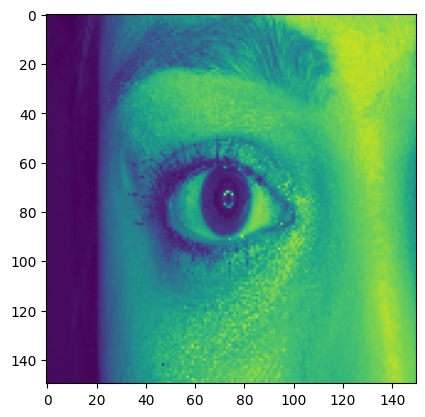

In [99]:
plt.imshow(out)
iris_rad

In [576]:
im = cv2.imread("ref.jpg")
im = cv2.cvtColor(np.float32(im), cv2.COLOR_BGR2GRAY)

_, thresh = cv2.threshold(im, 100, 255, cv2.THRESH_BINARY)
        # Now find the contours and then find the pupil in the contours.

contours, k, l = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
c = cv2.HoughCircles(contours, cv2.HOUGH_GRADIENT, 2, im.shape[0]/2)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


In [572]:
contour

(array([[[3695, 3455]]], dtype=int32),
 array([[[1576, 3455]]], dtype=int32),
 array([[[3600, 3453]],
 
        [[3600, 3455]]], dtype=int32),
 array([[[3597, 3453]],
 
        [[3597, 3455]],
 
        [[3598, 3455]],
 
        [[3598, 3454]]], dtype=int32),
 array([[[1544, 3453]]], dtype=int32),
 array([[[1567, 3452]]], dtype=int32),
 array([[[1527, 3452]],
 
        [[1526, 3453]],
 
        [[1525, 3453]],
 
        [[1526, 3454]],
 
        [[1527, 3454]],
 
        [[1528, 3455]],
 
        [[1529, 3455]],
 
        [[1528, 3455]],
 
        [[1527, 3454]]], dtype=int32),
 array([[[3688, 3448]],
 
        [[3688, 3451]],
 
        [[3688, 3450]],
 
        [[3689, 3449]],
 
        [[3689, 3448]]], dtype=int32),
 array([[[3663, 3448]],
 
        [[3664, 3447]],
 
        [[3665, 3448]],
 
        [[3664, 3449]]], dtype=int32),
 array([[[1528, 3448]],
 
        [[1529, 3448]]], dtype=int32),
 array([[[3673, 3447]],
 
        [[3674, 3446]],
 
        [[3675, 3447]],
 
        [[36

In [158]:
for l in cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]:
    print(l)
    for circle in l:
        print(circle)
        
        center = (circle[0], circle[1])

[[[3695 3455]]]
[[3695 3455]]


IndexError: index 1 is out of bounds for axis 0 with size 1

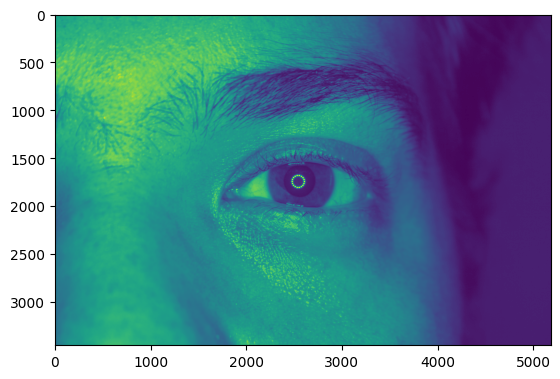

In [153]:
plt.imshow(im)

In [5]:
def partialDerivative(image, coord, rmin, rmax, sigma, n, feature):
    '''
        calculates the partial derivative of the normailzed line integral
        holding the centre coordinates constant
        and then smooths it by a gaussian of appropriate sigma
        rmin and rmax are the minimum and maximum values of radii expected
        function also returns the maximum value of blur and the corresponding radius
        with finite differnce vector blur
    :param image: preprocessed image
    :param coord: centre coordinates
    :param rmin: min radius
    :param rmax: max radius
    :param sigma: standard deviation of the gaussian
    :param n: number of sides of the polygon(for LineIntegral)
    :param feature: pupil or Iris
    :return: It gives finite differences vector, max value of blur
            and radius at max blur
    '''
    R = np.arange(rmin, rmax)
    count = R.shape[0]

    lineIntegral = []
    # lineIntegral = np.empty(7)

    for k in np.arange(0, count):
        # computing the normalized line integral for each radius
        temp = NormalLineIntegral(image, coord, R[k], n, feature)
        if temp == 0:
            # this case occurs iff the radius takes the circle out of the image
            # In this case,L is deleted as shown below and no more radii are taken for computation
            # (for that particular centre point).This is accomplished using the break statement
            break
        else:
            lineIntegral.append(temp)
            # np.append(lineIntegral,temp)
    if not isinstance(lineIntegral, np.ndarray):
        lineIntegral = np.array(lineIntegral)

    disc_diff = np.diff(lineIntegral)
    D = np.concatenate(([0], disc_diff))  # append one element at the beginning

    if sigma == 'inf':
        kernel = np.ones(7) / 7
    else:
        kernel = matlab_style_gauss2D([1, 5], sigma)  # generates a 5 member 1-D gaussian
        kernel = np.reshape(kernel, kernel.shape[1], order='F')

    blur = np.abs(convolve(D, kernel, 'same'))
    # Smooths the D vecor by 1-D convolution

    values, index = blur.max(0), blur.argmax(0)
    max_blur_radius = R[index]
    max_blur = blur[index]
    return max_blur, max_blur_radius, blur


def NormalLineIntegral(image, coord, r, n, feature):
    '''
      function to calculate the normalised line integral around a circular contour
      A polygon of large number of sides approximates a circle and hence is used
      here to calculate the line integral by summation
      if the search is for the pupil,the function uses the entire circle(polygon) for computing L
      for the iris only the lateral portions are used to mitigate the effect of occlusions
      that might occur at the top and/or at the bottom
    :param image: image to be processed
    :param coord: [x,y]  center coord of the circum center < Origin is Top Left Corner >
    :param r: radius of the circum circle
    :param n: number of sides
    :param feature: To indicate wheter search is for iris or pupil
    :return: the line integral divided by circumference
    '''
    theta = (2 * np.pi) / n  # angle subtended at the center by the sides
    # orient one of the radii to lie along the y axis
    rows, cols = image.shape
    angle = np.arange(theta, 2 * np.pi, theta)
    x = coord[0] - r * np.sin(angle)
    y = coord[1] + r * np.cos(angle)

    if not isinstance(x, np.ndarray):
        x = np.array(x)
    if not isinstance(y, np.ndarray):
        y = np.array(y)

    if np.any(x >= rows) or np.any(y >= cols) or np.any(x <= 1) or np.any(y <= 1):
        # This process returns L=0 for any circle that does not fit inside the image
        return 0
    if feature == 'pupil':
        s = 0
        for i in np.arange(0, n - 1):
            val = image[_round(x[i]), _round(y[i])]
            s += val
        line = s / n
        return line

    elif feature == 'iris':
        s = 0
        for i in np.arange(1, _round(n / 8)):
            val = image[_round(x[i]), _round(y[i])]
            s += val

        for i in np.arange(_round(3 * n / 8) + 1, _round((5 * n / 8))):
            val = image[_round(x[i]), _round(y[i])]
            s += val

        for i in np.arange(np.round((7 * n / 8)).astype(np.uint8) + 1, n - 1):
            val = image[_round(x[i]), _round(y[i])]
            s += val

        line = (2 * s) / n
        return line

    
def matlab_style_gauss2D(shape=(3, 3), sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m + 1, -n:n + 1]
    h = np.exp(-(x * x + y * y) / (2. * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h



In [57]:
image.shape

AttributeError: shape

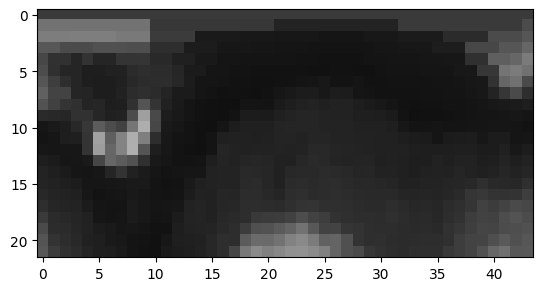

In [27]:
plt.imshow(cartisian_image.astype('uint8'))
Image.fromarray(cartisian_image)

In [127]:
print(iris_image_to_show[polarY][polarX])
print(polarY, polarX)

121
27 54


In [131]:
len(li_x)
# li_x.pop()

54

In [ ]:
image = 'L3.JPG'
img = cv2.imread(image,0)
img = cv2.medianBlur(img,5)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,10,param1=63,param2=70,minRadius=0,maxRadius=0)
#  cv.HoughCircles (image, circles, method, dp, minDist, param1 = 100, param2 = 100, minRadius = 0, maxRadius = 0)
# Parameters
# image	8-bit, single-channel, grayscale input image.
# circles	output vector of found circles(cv.CV_32FC3 type). Each vector is encoded as a 3-element floating-point vector (x,y,radius) .
# method	detection method(see cv.HoughModes). Currently, the only implemented method is HOUGH_GRADIENT
# dp	inverse ratio of the accumulator resolution to the image resolution. For example, if dp = 1 , the accumulator has the same resolution as the input image. If dp = 2 , the accumulator has half as big width and height.
# minDist	minimum distance between the centers of the detected circles. If the parameter is too small, multiple neighbor circles may be falsely detected in addition to a true one. If it is too large, some circles may be missed.
# param1	first method-specific parameter. In case of HOUGH_GRADIENT , it is the higher threshold of the two passed to the Canny edge detector (the lower one is twice smaller).
# param2	second method-specific parameter. In case of HOUGH_GRADIENT , it is the accumulator threshold for the circle centers at the detection stage. The smaller it is, the more false circles may be detected. Circles, corresponding to the larger accumulator values, will be returned first.
# minRadius	minimum circle radius.
# maxRadius	maximum circle radius.

# height,width = img.shape
# r = 0
# mask = np.zeros((height,width), np.uint8)
# for i in circles[0,:]:
#     cv2.circle(cimg,(i[0],i[1]),i[2],(0,0,0))
#     cv2.circle(mask,(i[0],i[1]),i[2],(255,255,255),thickness=0)
#     blank_image = cimg[:int(i[1]),:int(i[1])]

#     masked_data = cv2.bitwise_and(cimg, cimg, mask=mask)
#     _,thresh = cv2.threshold(mask,1,255,cv2.THRESH_BINARY)
#     contours = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
#     x,y,w,h = cv2.boundingRect(contours[0][0])
#     crop = masked_data[y:y+h,x:x+w]
#     r = i[2]


# plt.imshow(cimg)

In [101]:
len(li_y)

neww_li =[]
for i in range(len(li_x)):
    new_li =[]
    new_li.append(li_x[i])
    new_li.append(li_y[i])
    neww_li.append(new_li)
    

IndexError: list index out of range

In [104]:
len(li_x)

55

In [19]:
import numpy as np
from scipy.signal import convolve

_round = lambda x: np.round(x).astype(np.uint8)


def search(image, rmin, rmax, x, y, feature):
    '''
        function to detect the pupil  boundary
        it searches a certain subset of the image
        with a given radius range(rmin,rmax)
        around a 10*10 neighbourhood of the point x,y given as input
    :param image: image to be processed
    :param rmin: min radius
    :param rmax: max radius
    :param x: x - coord of center point
    :param y: y - coord of center point
    :param feature: 'pupil' or 'iris'
    :return: Center coord followed by radius
    '''
    sigma = 0.5
    maxRadius = np.zeros(image.shape)
    maxBlur = np.zeros(image.shape)
    for i in np.arange(int(x) - 5, int(x) + 5):
        for j in np.arange(int(y) - 5, int(y) + 5):
            max_blur, max_blur_radius, blur = partialDerivative(image, [i, j], rmin, rmax, sigma, 600, feature)
            maxRadius[i, j] = max_blur_radius
            maxBlur[i, j] = max_blur
    X, Y = np.where(maxBlur == maxBlur.max())
    radius = maxRadius[X, Y]
    coordPupil = np.array([X, Y, radius])
    return coordPupil


def NormalLineIntegral(image, coord, r, n, feature):
    '''
      function to calculate the normalised line integral around a circular contour
      A polygon of large number of sides approximates a circle and hence is used
      here to calculate the line integral by summation
      if the search is for the pupil,the function uses the entire circle(polygon) for computing L
      for the iris only the lateral portions are used to mitigate the effect of occlusions
      that might occur at the top and/or at the bottom
    :param image: image to be processed
    :param coord: [x,y]  center coord of the circum center < Origin is Top Left Corner >
    :param r: radius of the circum circle
    :param n: number of sides
    :param feature: To indicate wheter search is for iris or pupil
    :return: the line integral divided by circumference
    '''
    theta = (2 * np.pi) / n  # angle subtended at the center by the sides
    # orient one of the radii to lie along the y axis
    rows, cols = image.shape
    angle = np.arange(theta, 2 * np.pi, theta)
    x = coord[0] - r * np.sin(angle)
    y = coord[1] + r * np.cos(angle)

    if not isinstance(x, np.ndarray):
        x = np.array(x)
    if not isinstance(y, np.ndarray):
        y = np.array(y)

    if np.any(x >= rows) or np.any(y >= cols) or np.any(x <= 1) or np.any(y <= 1):
        # This process returns L=0 for any circle that does not fit inside the image
        return 0
    if feature == 'pupil':
        s = 0
        for i in np.arange(0, n - 1):
            val = image[_round(x[i]), _round(y[i])]
            s += val
        line = s / n
        return line

    elif feature == 'iris':
        s = 0
        for i in np.arange(1, _round(n / 8)):
            val = image[_round(x[i]), _round(y[i])]
            s += val

        for i in np.arange(_round(3 * n / 8) + 1, _round((5 * n / 8))):
            val = image[_round(x[i]), _round(y[i])]
            s += val

        for i in np.arange(np.round((7 * n / 8)).astype(np.uint8) + 1, n - 1):
            val = image[_round(x[i]), _round(y[i])]
            s += val

        line = (2 * s) / n
        return line


def matlab_style_gauss2D(shape=(3, 3), sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m + 1, -n:n + 1]
    h = np.exp(-(x * x + y * y) / (2. * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h


def partialDerivative(image, coord, rmin, rmax, sigma, n, feature):
    '''
        calculates the partial derivative of the normailzed line integral
        holding the centre coordinates constant
        and then smooths it by a gaussian of appropriate sigma
        rmin and rmax are the minimum and maximum values of radii expected
        function also returns the maximum value of blur and the corresponding radius
        with finite differnce vector blur
    :param image: preprocessed image
    :param coord: centre coordinates
    :param rmin: min radius
    :param rmax: max radius
    :param sigma: standard deviation of the gaussian
    :param n: number of sides of the polygon(for LineIntegral)
    :param feature: pupil or Iris
    :return: It gives finite differences vector, max value of blur
            and radius at max blur
    '''
    R = np.arange(rmin, rmax)
    count = R.shape[0]

    lineIntegral = []
    # lineIntegral = np.empty(7)

    for k in np.arange(0, count):
        # computing the normalized line integral for each radius
        temp = NormalLineIntegral(image, coord, R[k], n, feature)
        if temp == 0:
            # this case occurs iff the radius takes the circle out of the image
            # In this case,L is deleted as shown below and no more radii are taken for computation
            # (for that particular centre point).This is accomplished using the break statement
            break
        else:
            lineIntegral.append(temp)
            # np.append(lineIntegral,temp)
    if not isinstance(lineIntegral, np.ndarray):
        lineIntegral = np.array(lineIntegral)

    disc_diff = np.diff(lineIntegral)
    D = np.concatenate(([0], disc_diff))  # append one element at the beginning

    if sigma == 'inf':
        kernel = np.ones(7) / 7
    else:
        kernel = matlab_style_gauss2D([1, 5], sigma)  # generates a 5 member 1-D gaussian
        kernel = np.reshape(kernel, kernel.shape[1], order='F')

    blur = np.abs(convolve(D, kernel, 'same'))
    # Smooths the D vecor by 1-D convolution

    values, index = blur.max(0), blur.argmax(0)
    max_blur_radius = R[index]
    max_blur = blur[index]
    return max_blur, max_blur_radius, blur


def drawcircle(I, C, r, n=600):
    '''
        generate the pixels on the boundary of a regular polygon of n sides
        the polygon approximates a circle of radius r and is used to draw the circle
    :param I: image to be processed
    :param C: [x,y] Centre coordinates of the circumcircle
    :param r: radius of the circumcircle
    :param n: no of sides
    :return: Image with circle
    '''
    theta = (2 * np.pi) / n
    rows, cols = I.shape
    angle = np.arange(theta, 2 * np.pi, theta)

    x = C[0] - r * np.sin(angle)
    y = C[1] + r * np.cos(angle)

    if np.any(x >= rows) or np.any(y >= cols) or np.any(x <= 1) or np.any(y <= 1):
        return I
    for i in np.arange(1, n - 1):
        I[np.round(x[i]).astype(np.uint8), np.round(y[i]).astype(np.uint8)] = 1
    return I

In [18]:
import utils
dir(utils.__builtins__)

['__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'items',
 'keys',
 'pop',
 'popitem',
 'setdefault',
 'update',
 'values']

In [105]:
# print(iris_image_to_show[20][20])
# plt.imshow(iris_image_to_show)
src = np.asarray(Image.open("L3.JPG"))
resize_img = cv2.resize(src, new_size)
eye_image = cv2.cvtColor(resize_img, cv2.COLOR_RGB2GRAY)
eye_circles = cv2.HoughCircles(eye_image, cv2.HOUGH_GRADIENT, 2, 100,  minRadius = 0, maxRadius = 200)

In [106]:
# print(iris_image_to_show[20][20])
# plt.imshow(np.array(im))
eye_circles

array([[[43., 75., 35.]]], dtype=float32)

In [100]:
iris_image_to_show

array([], shape=(90, 0, 3), dtype=uint8)

L1.JPG
D:\5505\iris_images\train_images\1\L1.JPG
1
yes
((74, 74), 10)
(150, 150)
75
L2.JPG
D:\5505\iris_images\train_images\1\L2.JPG
2
yes
((76, 74), 10)
(150, 150)
75
R1.JPG
D:\5505\iris_images\train_images\1\R1.JPG
3
yes
((74, 78), 10)
(150, 150)
75
R2.JPG
D:\5505\iris_images\train_images\1\R2.JPG
4
yes
((72, 76), 11)
(150, 150)
75
no of files 4
..................................
1\R2.JPG
['1', 'R2.JPG']
L2.JPG
D:\5505\iris_images\train_images\10\L2.JPG
5
yes
((72, 76), 10)
(150, 150)
75
L3.JPG
D:\5505\iris_images\train_images\10\L3.JPG
6
yes
((72, 76), 10)
(150, 150)
75
R2.JPG
D:\5505\iris_images\train_images\10\R2.JPG
7
yes
((74, 76), 10)
(150, 150)
75
R3.JPG
D:\5505\iris_images\train_images\10\R3.JPG
8
yes
((72, 78), 11)
(150, 150)
75
no of files 4
..................................
10\R3.JPG
['10', 'R3.JPG']
L2.JPG
D:\5505\iris_images\train_images\100\L2.JPG
9
yes
((74, 74), 13)
(150, 150)
75
L3.JPG
D:\5505\iris_images\train_images\100\L3.JPG
10
yes
((74, 76), 13)
(150, 150)
75
R

yes
((74, 76), 10)
(150, 150)
75
R2.JPG
D:\5505\iris_images\train_images\116\R2.JPG
79
yes
((74, 74), 10)
(150, 150)
75
R3.JPG
D:\5505\iris_images\train_images\116\R3.JPG
80
yes
((74, 78), 10)
(150, 150)
75
no of files 4
..................................
116\R3.JPG
['116', 'R3.JPG']
L2.JPG
D:\5505\iris_images\train_images\117\L2.JPG
81
yes
((74, 74), 14)
(150, 150)
75
L3.JPG
D:\5505\iris_images\train_images\117\L3.JPG
82
yes
((74, 74), 14)
(150, 150)
75
R2.JPG
D:\5505\iris_images\train_images\117\R2.JPG
83
yes
((72, 78), 14)
(150, 150)
75
R3.JPG
D:\5505\iris_images\train_images\117\R3.JPG
84
yes
((72, 78), 14)
(150, 150)
75
no of files 4
..................................
117\R3.JPG
['117', 'R3.JPG']
L2.JPG
D:\5505\iris_images\train_images\118\L2.JPG
85
yes
((72, 78), 12)
(150, 150)
75
L3.JPG
D:\5505\iris_images\train_images\118\L3.JPG
86
yes
((72, 78), 12)
(150, 150)
75
R2.JPG
D:\5505\iris_images\train_images\118\R2.JPG
87
yes
((74, 76), 12)
(150, 150)
75
R3.JPG
D:\5505\iris_images\t

yes
((74, 78), 11)
(150, 150)
75
R3.JPG
D:\5505\iris_images\train_images\133\R3.JPG
156
yes
((74, 76), 12)
(150, 150)
75
no of files 4
..................................
133\R3.JPG
['133', 'R3.JPG']
L2.JPG
D:\5505\iris_images\train_images\134\L2.JPG
157
yes
((74, 76), 13)
(150, 150)
75
L3.JPG
D:\5505\iris_images\train_images\134\L3.JPG
158
yes
((72, 76), 13)
(150, 150)
75
R2.JPG
D:\5505\iris_images\train_images\134\R2.JPG
159
yes
((74, 76), 13)
(150, 150)
75
R3.JPG
D:\5505\iris_images\train_images\134\R3.JPG
160
yes
((74, 74), 13)
(150, 150)
75
no of files 4
..................................
134\R3.JPG
['134', 'R3.JPG']
L2.JPG
D:\5505\iris_images\train_images\135\L2.JPG
161
yes
((72, 74), 12)
(150, 150)
75
L3.JPG
D:\5505\iris_images\train_images\135\L3.JPG
162
yes
((74, 78), 12)
(150, 150)
75
R2.JPG
D:\5505\iris_images\train_images\135\R2.JPG
163
yes
((74, 78), 12)
(150, 150)
75
R3.JPG
D:\5505\iris_images\train_images\135\R3.JPG
164
yes
((74, 76), 12)
(150, 150)
75
no of files 4
.....

yes
((74, 76), 14)
(150, 150)
75
no of files 4
..................................
150\R3.JPG
['150', 'R3.JPG']
L2.JPG
D:\5505\iris_images\train_images\16\L2.JPG
233
yes
((72, 76), 10)
(150, 150)
75
L3.JPG
D:\5505\iris_images\train_images\16\L3.JPG
234
yes
((72, 76), 10)
(150, 150)
75
R2.JPG
D:\5505\iris_images\train_images\16\R2.JPG
235
yes
((74, 76), 10)
(150, 150)
75
R3.JPG
D:\5505\iris_images\train_images\16\R3.JPG
236
yes
((74, 74), 12)
(150, 150)
75
no of files 4
..................................
16\R3.JPG
['16', 'R3.JPG']
L2.JPG
D:\5505\iris_images\train_images\17\L2.JPG
237
yes
((74, 80), 10)
(150, 150)
75
L3.JPG
D:\5505\iris_images\train_images\17\L3.JPG
238
yes
((72, 78), 10)
(150, 150)
75
R2.JPG
D:\5505\iris_images\train_images\17\R2.JPG
239
yes
((74, 80), 11)
(150, 150)
75
R3.JPG
D:\5505\iris_images\train_images\17\R3.JPG
240
yes
((74, 80), 10)
(150, 150)
75
no of files 4
..................................
17\R3.JPG
['17', 'R3.JPG']
L2.JPG
D:\5505\iris_images\train_images\1

yes
((74, 76), 12)
(150, 150)
75
L3.JPG
D:\5505\iris_images\train_images\33\L3.JPG
310
yes
((74, 78), 12)
(150, 150)
75
R2.JPG
D:\5505\iris_images\train_images\33\R2.JPG
311
yes
((74, 76), 12)
(150, 150)
75
R3.JPG
D:\5505\iris_images\train_images\33\R3.JPG
312
yes
((72, 74), 12)
(150, 150)
75
no of files 4
..................................
33\R3.JPG
['33', 'R3.JPG']
L2.JPG
D:\5505\iris_images\train_images\34\L2.JPG
313
yes
((74, 70), 10)
(150, 150)
75
L3.JPG
D:\5505\iris_images\train_images\34\L3.JPG
314
yes
((74, 76), 10)
(150, 150)
75
R2.JPG
D:\5505\iris_images\train_images\34\R2.JPG
315
yes
((74, 74), 10)
(150, 150)
75
R3.JPG
D:\5505\iris_images\train_images\34\R3.JPG
316
yes
((74, 74), 10)
(150, 150)
75
no of files 4
..................................
34\R3.JPG
['34', 'R3.JPG']
L2.JPG
D:\5505\iris_images\train_images\35\L2.JPG
317
yes
((74, 78), 12)
(150, 150)
75
L3.JPG
D:\5505\iris_images\train_images\35\L3.JPG
318
yes
((72, 72), 10)
(150, 150)
75
R2.JPG
D:\5505\iris_images\train

yes
((74, 76), 10)
(150, 150)
75
R2.JPG
D:\5505\iris_images\train_images\50\R2.JPG
388
yes
((76, 74), 12)
(150, 150)
75
no of files 4
..................................
50\R2.JPG
['50', 'R2.JPG']
L1.JPG
D:\5505\iris_images\train_images\51\L1.JPG
389
yes
((68, 74), 11)
(150, 150)
75
L2.JPG
D:\5505\iris_images\train_images\51\L2.JPG
390
yes
((74, 76), 10)
(150, 150)
75
R1.JPG
D:\5505\iris_images\train_images\51\R1.JPG
391
yes
((72, 76), 12)
(150, 150)
75
R2.JPG
D:\5505\iris_images\train_images\51\R2.JPG
392
yes
((74, 76), 12)
(150, 150)
75
no of files 4
..................................
51\R2.JPG
['51', 'R2.JPG']
L1.JPG
D:\5505\iris_images\train_images\52\L1.JPG
393
yes
((76, 78), 10)
(150, 150)
75
L2.JPG
D:\5505\iris_images\train_images\52\L2.JPG
394
yes
((74, 76), 10)
(150, 150)
75
R1.JPG
D:\5505\iris_images\train_images\52\R1.JPG
395
yes
((74, 76), 10)
(150, 150)
75
R2.JPG
D:\5505\iris_images\train_images\52\R2.JPG
396
yes
((74, 78), 10)
(150, 150)
75
no of files 4
..................

yes
((74, 72), 12)
(150, 150)
75
L2.JPG
D:\5505\iris_images\train_images\69\L2.JPG
466
yes
((72, 72), 12)
(150, 150)
75
R1.JPG
D:\5505\iris_images\train_images\69\R1.JPG
467
yes
((72, 70), 12)
(150, 150)
75
R2.JPG
D:\5505\iris_images\train_images\69\R2.JPG
468
yes
((72, 72), 12)
(150, 150)
75
no of files 4
..................................
69\R2.JPG
['69', 'R2.JPG']
L1.JPG
D:\5505\iris_images\train_images\7\L1.JPG
469
yes
((74, 76), 12)
(150, 150)
75
L2.JPG
D:\5505\iris_images\train_images\7\L2.JPG
470
yes
((74, 78), 12)
(150, 150)
75
R1.JPG
D:\5505\iris_images\train_images\7\R1.JPG
471
yes
((72, 74), 12)
(150, 150)
75
R2.JPG
D:\5505\iris_images\train_images\7\R2.JPG
472
yes
((74, 76), 12)
(150, 150)
75
no of files 4
..................................
7\R2.JPG
['7', 'R2.JPG']
L1.JPG
D:\5505\iris_images\train_images\70\L1.JPG
473
yes
((74, 76), 10)
(150, 150)
75
L2.JPG
D:\5505\iris_images\train_images\70\L2.JPG
474
yes
((74, 76), 10)
(150, 150)
75
R1.JPG
D:\5505\iris_images\train_image

yes
((74, 78), 13)
(150, 150)
75
R2.JPG
D:\5505\iris_images\train_images\86\R2.JPG
544
yes
((74, 76), 13)
(150, 150)
75
no of files 4
..................................
86\R2.JPG
['86', 'R2.JPG']
L1.JPG
D:\5505\iris_images\train_images\87\L1.JPG
545
yes
((74, 78), 13)
(150, 150)
75
L2.JPG
D:\5505\iris_images\train_images\87\L2.JPG
546
yes
((74, 76), 13)
(150, 150)
75
R1.JPG
D:\5505\iris_images\train_images\87\R1.JPG
547
yes
((74, 78), 12)
(150, 150)
75
R2.JPG
D:\5505\iris_images\train_images\87\R2.JPG
548
yes
((74, 76), 12)
(150, 150)
75
no of files 4
..................................
87\R2.JPG
['87', 'R2.JPG']
L.JPG
D:\5505\iris_images\train_images\88\L.JPG
549
yes
((74, 78), 10)
(150, 150)
75
L2.JPG
D:\5505\iris_images\train_images\88\L2.JPG
550
yes
((74, 78), 11)
(150, 150)
75
R1.JPG
D:\5505\iris_images\train_images\88\R1.JPG
551
yes
((72, 76), 11)
(150, 150)
75
R2.JPG
D:\5505\iris_images\train_images\88\R2.JPG
552
yes
((74, 76), 12)
(150, 150)
75
no of files 4
....................

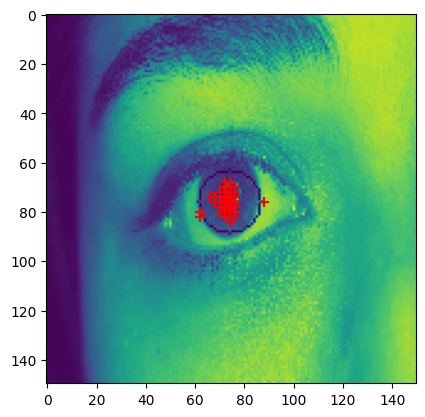

In [381]:



root = 'D:\\5505\\iris_images\\train_images'
pattern = ".JPG"
i=0
x_train_nor = []
x_train = []
folder_li = []
x_train_cart= []
for path, subdirs, files in os.walk(root):
    files1=0
    for name in files:
        
        print(name)
        # if fnmatch(name, pattern):
        print(os.path.join(path, name))
        img = os.path.join(path, name)
        files1=files1+1
        i=i+1
        print(i)
   
        src = cv2.imread(img, cv2.IMREAD_UNCHANGED)
        # print(src.shape)
        new_size = (150, 150) 
        resize_img = cv2.resize(src, new_size)
        gray_img = cv2.cvtColor(resize_img, cv2.COLOR_BGR2GRAY)
        # plt.imshow(gray_img)
        
        answer = find_iris(gray_img, daugman_start=10, daugman_end=30, daugman_step=1, points_step=2)
        print(answer)
        
        iris_center, iris_rad = answer
        out = gray_img.copy()
        
        #cv2.circle(out, iris_center, iris_rad, (0, 0, 255), 1)
        iris_img = cv2.circle(out, iris_center, iris_rad, (0, 0, 255), 1)
        _ = plt.imshow(out[::,::])
        plt.scatter(iris_center[0], iris_center[1], 50, c="r", marker="+") # plot markers
       # plt.show()
        blank = np.zeros(out.shape[:2], dtype='uint8')
        
        center_coordinates = iris_center
        
        radius = iris_rad
        
        mask = cv2.circle(blank, center_coordinates, radius, 255, -1)
        
        masked = cv2.bitwise_and(out, out, mask=mask)
#         cv2.imshow('Output', masked)
#         cv2.waitKey(5000)
#         cv2.destroyAllWindows()
        q = np.arange(0.00, np.pi*2, 0.01) #theta
        iris_image_to_show = masked #cv2.imread("maskimg.jpg", cv2.IMREAD_UNCHANGED)
        print(iris_image_to_show.shape)
        inn = np.arange(0, int(iris_image_to_show.shape[0]/2), 1) #radius
        print(inn.size)
        cartisian_image = np.empty(shape = [inn.size, int(iris_image_to_show.shape[1]), 3])
        m = interp1d([np.pi*2, 0],[0,iris_image_to_show.shape[1]])

        for r in inn:
            for t in q:
                polarX = int((r * np.cos(t)) + iris_image_to_show.shape[1]/2)
                polarY = int((r * np.sin(t)) + iris_image_to_show.shape[0]/2)
                cartisian_image[r][int(m(t) - 1)] = iris_image_to_show[polarY][polarX]

        im = Image.fromarray(iris_image_to_show)
        # im.save('eye.jpeg')
        cartisian_image = cartisian_image.astype('uint8')
        im = Image.fromarray(cartisian_image)
        #im.save('cartesian_eye.jpeg')
        
                
        img_normalized = cv2.normalize(masked, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
#         x_train.append(img_normalized)
        
        zer_mom = mahotas.features.zernike_moments(masked, 10)
        
        x_train.append(zer_mom)
        x_train_nor.append(img_normalized)
        x_train_cart.append(np.array(im))
    if files1==4:
        print("no of files", files1)
        print("..................................")
        print(img.split("train_images\\")[1])
        k =img.split("train_images\\")[1]
        print(k.split("\\"))
        num_str = k.split("\\")
        folder = int(num_str[0])
        folder_li.append(folder)
    
    
        
#         cv2.imshow('n',img_normalized)
#         cv2.waitKey(5000)
#         cv2.destroyAllWindows()

In [12]:
import pickle

with open('x_train_cart', 'wb') as fp:
    pickle.dump(x_train_cart, fp)
# with open('outfile_test300', 'wb') as fp:
#     pickle.dump(y_train, fp)

In [320]:
gray_img.shape

(150, 150)

In [4]:
len(folder_li)

150

In [5]:
folder_li

[1,
 10,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 11,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 12,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 13,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 14,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 15,
 150,
 16,
 17,
 18,
 19,
 2,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 3,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 4,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 5,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 6,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 7,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 8,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 9,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

In [6]:
len(x_train)

600

In [ ]:



root = 'D:\\5505\\iris_images\\test_images'
pattern = ".JPG"
i=0
x_train = []
for path, subdirs, files in os.walk(root):
    for name in files:
        print(name)
        # if fnmatch(name, pattern):
        print(os.path.join(path, name))
        img = os.path.join(path, name)
        i=i+1
        print(i)
   
        src = cv2.imread(img, cv2.IMREAD_UNCHANGED)
        # print(src.shape)
        new_size = (150, 150) 
        resize_img = cv2.resize(src, new_size)
        gray_img = cv2.cvtColor(resize_img, cv2.COLOR_BGR2GRAY)
        # plt.imshow(gray_img)
        
        answer = find_iris(gray_img, daugman_start=10, daugman_end=30, daugman_step=1, points_step=2)
        print(answer)
        
        iris_center, iris_rad = answer
        out = gray_img.copy()
        
        #cv2.circle(out, iris_center, iris_rad, (0, 0, 255), 1)
        iris_img = cv2.circle(out, iris_center, iris_rad, (0, 0, 255), 1)
        _ = plt.imshow(out[::,::])
        plt.scatter(iris_center[0], iris_center[1], 50, c="r", marker="+") # plot markers
       # plt.show()
        blank = np.zeros(out.shape[:2], dtype='uint8')
        
        center_coordinates = iris_center
        
        radius = iris_rad
        
        mask = cv2.circle(blank, center_coordinates, radius, 255, -1)
        
        masked = cv2.bitwise_and(out, out, mask=mask)
#         cv2.imshow('Output', masked)
#         cv2.waitKey(5000)
#         cv2.destroyAllWindows()
        
        img_normalized = cv2.normalize(masked, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
#         x_train.append(img_normalized)
        
        zer_mom = mahotas.features.zernike_moments(masked, 10)
        
        x_train.append(zer_mom)
        x_train.append(img_normalized)
        
    
        
#         cv2.imshow('n',img_normalized)
#         cv2.waitKey(5000)
#         cv2.destroyAllWindows()

In [383]:



# root = 'D:\\5505\\iris_images\\test_images'
# pattern = ".JPG"
# i=0
# x_test_zer = []
# x_test_nor = []
# for path, subdirs, files in os.walk(root):
#     for name in files:
#         print(name)
#         # if fnmatch(name, pattern):
#         print(os.path.join(path, name))
#         img = os.path.join(path, name)
#         i=i+1
#         print(i)
   
#         src = cv2.imread(img, cv2.IMREAD_UNCHANGED)
#         # print(src.shape)
#         new_size = (150, 150) 
#         resize_img = cv2.resize(src, new_size)
#         gray_img = cv2.cvtColor(resize_img, cv2.COLOR_BGR2GRAY)
#         # plt.imshow(gray_img)
        
#         answer = find_iris(gray_img, daugman_start=10, daugman_end=30, daugman_step=1, points_step=2)
#         print(answer)
        
#         iris_center, iris_rad = answer
#         out = gray_img.copy()
        
#         #cv2.circle(out, iris_center, iris_rad, (0, 0, 255), 1)
#         iris_img = cv2.circle(out, iris_center, iris_rad, (0, 0, 255), 1)
#         _ = plt.imshow(out[::,::])
#         plt.scatter(iris_center[0], iris_center[1], 50, c="r", marker="+") # plot markers
#        # plt.show()
#         blank = np.zeros(out.shape[:2], dtype='uint8')
        
#         center_coordinates = iris_center
        
#         radius = iris_rad
        
#         mask = cv2.circle(blank, center_coordinates, radius, 255, -1)
        
#         masked = cv2.bitwise_and(out, out, mask=mask)
# #         cv2.imshow('Output', masked)
# #         cv2.waitKey(5000)
# #         cv2.destroyAllWindows()
        
#         img_normalized = cv2.normalize(masked, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
# #         x_train.append(img_normalized)
        
#         zer_mom = mahotas.features.zernike_moments(masked, 10)
        
#         x_test_zer.append(zer_mom)
#         x_test_nor.append(img_normalized)
        
    
        
# #         cv2.imshow('n',img_normalized)
# #         cv2.waitKey(5000)
# #         cv2.destroyAllWindows()

In [384]:



# root = 'D:\\5505\\iris_images\\train_images'
# pattern = ".JPG"
# i=0
# x_train_nor = []
# x_train = []
# for path, subdirs, files in os.walk(root):
#     for name in files:
#         print(name)
#         # if fnmatch(name, pattern):
#         print(os.path.join(path, name))
#         img = os.path.join(path, name)
#         i=i+1
#         print(i)
   
#         src = cv2.imread(img, cv2.IMREAD_UNCHANGED)
#         # print(src.shape)
#         new_size = (150, 150) 
#         resize_img = cv2.resize(src, new_size)
#         gray_img = cv2.cvtColor(resize_img, cv2.COLOR_BGR2GRAY)
#         # plt.imshow(gray_img)
        
#         answer = find_iris(gray_img, daugman_start=10, daugman_end=30, daugman_step=1, points_step=2)
#         print(answer)
        
#         iris_center, iris_rad = answer
#         out = gray_img.copy()
        
#         #cv2.circle(out, iris_center, iris_rad, (0, 0, 255), 1)
#         iris_img = cv2.circle(out, iris_center, iris_rad, (0, 0, 255), 1)
#         _ = plt.imshow(out[::,::])
#         plt.scatter(iris_center[0], iris_center[1], 50, c="r", marker="+") # plot markers
#        # plt.show()
#         blank = np.zeros(out.shape[:2], dtype='uint8')
        
#         center_coordinates = iris_center
        
#         radius = iris_rad
        
#         mask = cv2.circle(blank, center_coordinates, radius, 255, -1)
        
#         masked = cv2.bitwise_and(out, out, mask=mask)
# #         cv2.imshow('Output', masked)
# #         cv2.waitKey(5000)
# #         cv2.destroyAllWindows()
        
#         img_normalized = cv2.normalize(masked, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
# #         x_train.append(img_normalized)
        
#         zer_mom = mahotas.features.zernike_moments(masked, 10)
        
#         x_train.append(zer_mom)
#         x_train_nor.append(img_normalized)
    
        
# #         cv2.imshow('n',img_normalized)
# #         cv2.waitKey(5000)
# #         cv2.destroyAllWindows()

In [278]:
zer_mom = mahotas.features.zernike_moments(masked, 10)
zer_mom
# value = mahotas.features.zernike(img, degree, radius)

array([0.31830989, 0.03347969, 0.03343083, 0.01238681, 0.01938238,
       0.02288447, 0.00667452, 0.01523555, 0.0185937 , 0.03342032,
       0.0288531 , 0.00789906, 0.04456941, 0.02800328, 0.01018876,
       0.02097827, 0.02914477, 0.05626065, 0.02110715, 0.01724652,
       0.02235654, 0.00520781, 0.06924183, 0.01416384, 0.01199306])

In [35]:
import pandas as pd


df = pd.read_excel("METADATA.xlsx", nrows=704,sheet_name="Sheet1")
df

M
0    M
1    M
2    M
3    F
4    F
..  ..
698  M
699  F
700  M
701  M
702  F

[703 rows x 1 columns]

In [ ]:
import pandas as pd


df = pd.read_excel("METADATA.xlsx", nrows=704,sheet_name="Sheet1")
df
li = list(df['M'])
li.insert(0, 'M')
df1 = pd.DataFrame()
df1['gender'] = li
new_li = []
for i in li:
    if i=="M":
        new_li.append(1)
    else:
        new_li.append(0)
df1['nor'] = new_li
df1 = df1.reset_index()
df1.index = df1.index + 1
di = {}
for i in df1.index.values:
    di[i] = df1.iloc[i-1]['nor']
new_di = {}
y_train = []
for i in folder_li:
    y_train.append(di[i])
    
y_train  

In [118]:
di

{1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 1,
 10: 0,
 11: 1,
 12: 1,
 13: 1,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 1,
 19: 1,
 20: 0,
 21: 1,
 22: 1,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 1,
 34: 1,
 35: 0,
 36: 1,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 1,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 1,
 50: 1,
 51: 1,
 52: 1,
 53: 1,
 54: 1,
 55: 1,
 56: 1,
 57: 1,
 58: 1,
 59: 0,
 60: 0,
 61: 1,
 62: 1,
 63: 0,
 64: 0,
 65: 0,
 66: 1,
 67: 1,
 68: 1,
 69: 1,
 70: 0,
 71: 0,
 72: 1,
 73: 1,
 74: 0,
 75: 0,
 76: 1,
 77: 1,
 78: 0,
 79: 0,
 80: 0,
 81: 1,
 82: 0,
 83: 0,
 84: 0,
 85: 1,
 86: 0,
 87: 0,
 88: 1,
 89: 1,
 90: 1,
 91: 0,
 92: 1,
 93: 1,
 94: 0,
 95: 0,
 96: 1,
 97: 0,
 98: 0,
 99: 0,
 100: 0,
 101: 1,
 102: 0,
 103: 1,
 104: 1,
 105: 0,
 106: 0,
 107: 1,
 108: 1,
 109: 0,
 110: 0,
 111: 0,
 112: 1,
 113: 0,
 114: 0,
 115: 0,
 116: 0,
 117: 0,
 118: 0,
 119: 0,
 120: 0,
 121: 0,
 122: 0,
 123: 1,
 

In [36]:
li = list(df['M'])
len(li)
li

['M',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'M',
 'F',
 'M',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'M',
 'M',
 'F',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'M',
 'M',
 'F',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'F',
 'F',
 'M',
 'M',
 'F',
 'F',
 'F',
 'M',
 'M',
 'M',
 'M',
 'F',
 'F',
 'M',
 'M',
 'F',
 'F',
 'M',
 'M',
 'F',
 'F',
 'F',
 'M',
 'F',
 'F',
 'F',
 'M',
 'F',
 'F',
 'M',
 'M',
 'M',
 'F',
 'M',
 'M',
 'F',
 'F',
 'M',
 'F',
 'F',
 'F',
 'F',
 'M',
 'F',
 'M',
 'M',
 'F',
 'F',
 'M',
 'M',
 'F',
 'F',
 'F',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'M',
 'M',
 'M',
 'M',
 'F',
 'F',
 'M',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'M',
 'F',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'M',
 'M',
 'F',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 'M',
 'F',
 'F',
 'M',
 'M'

In [37]:
li.insert(0, 'M')
len(li)
li

['M',
 'M',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'M',
 'F',
 'M',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'M',
 'M',
 'F',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'M',
 'M',
 'F',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'F',
 'F',
 'M',
 'M',
 'F',
 'F',
 'F',
 'M',
 'M',
 'M',
 'M',
 'F',
 'F',
 'M',
 'M',
 'F',
 'F',
 'M',
 'M',
 'F',
 'F',
 'F',
 'M',
 'F',
 'F',
 'F',
 'M',
 'F',
 'F',
 'M',
 'M',
 'M',
 'F',
 'M',
 'M',
 'F',
 'F',
 'M',
 'F',
 'F',
 'F',
 'F',
 'M',
 'F',
 'M',
 'M',
 'F',
 'F',
 'M',
 'M',
 'F',
 'F',
 'F',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'M',
 'M',
 'M',
 'M',
 'F',
 'F',
 'M',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'M',
 'F',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'M',
 'M',
 'F',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 'M',
 'F',
 'F',
 'M'

In [38]:
df1 = pd.DataFrame()
df1['gender'] = li
df1

gender
0        M
1        M
2        M
3        M
4        F
..     ...
699      M
700      F
701      M
702      M
703      F

[704 rows x 1 columns]

In [39]:
new_li = []
for i in li:
    if i=="M":
        new_li.append(1)
    else:
        new_li.append(0)

In [40]:
first = new_li[0:150]
first

[1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0]

In [42]:
df1

gender  nor
0        M    1
1        M    1
2        M    1
3        M    1
4        F    0
..     ...  ...
699      M    1
700      F    0
701      M    1
702      M    1
703      F    0

[704 rows x 2 columns]

In [41]:
df1['nor'] = new_li
df1

gender  nor
0        M    1
1        M    1
2        M    1
3        M    1
4        F    0
..     ...  ...
699      M    1
700      F    0
701      M    1
702      M    1
703      F    0

[704 rows x 2 columns]

In [43]:
df1 = df1.reset_index()
df1.index = df1.index + 1
df1

index gender  nor
1        0      M    1
2        1      M    1
3        2      M    1
4        3      M    1
5        4      F    0
..     ...    ...  ...
700    699      M    1
701    700      F    0
702    701      M    1
703    702      M    1
704    703      F    0

[704 rows x 3 columns]

In [63]:
di = {}
for i in df1.index.values:
    di[i] = df1.iloc[i-1]['nor']
    

In [65]:
new_di = {}
y_train = []
for i in folder_li:
    y_train.append(di[i])
    
y_train    

[1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0]

In [15]:
x_train_cart_copy = x_train_cart


In [21]:
import pickle

with open ('x_train_cart451-740', 'rb') as fp:
    itemlist = pickle.load(fp)
# print(len(itemlist))
itemlist

[array([[[ 34,  34,  34],
         [ 34,  34,  34],
         [ 34,  34,  34],
         ...,
         [ 34,  34,  34],
         [ 34,  34,  34],
         [ 34,  34,  34]],
 
        [[ 35,  35,  35],
         [ 35,  35,  35],
         [ 35,  35,  35],
         ...,
         [ 34,  34,  34],
         [ 34,  34,  34],
         [ 44,  44,  44]],
 
        [[ 53,  53,  53],
         [ 53,  53,  53],
         [ 53,  53,  53],
         ...,
         [ 44,  44,  44],
         [ 44,  44,  44],
         [ 64,  64,  64]],
 
        ...,
 
        [[ 51,  51,  51],
         [ 30,  30,  30],
         [ 34,  34,  34],
         ...,
         [ 63,  63,  63],
         [ 58,  58,  58],
         [ 67,  67,  67]],
 
        [[ 58,  58,  58],
         [ 34,  34,  34],
         [ 36,  36,  36],
         ...,
         [ 80,  80,  80],
         [ 76,  76,  76],
         [ 91,  91,  91]],
 
        [[ 70,  70,  70],
         [ 45,  45,  45],
         [ 45,  45,  45],
         ...,
         [111, 111, 111],
  

In [22]:

for i in itemlist:
    x_train_cart_copy.append(i)


In [31]:
print(len(x_train_cart_copy))
for i in x_train_cart_copy:
    print(i.shape)

2816
(20, 40, 3)
(20, 40, 3)
(20, 40, 3)
(22, 44, 3)
(20, 40, 3)
(20, 40, 3)
(20, 40, 3)
(22, 44, 3)
(26, 52, 3)
(26, 52, 3)
(20, 40, 3)
(24, 48, 3)
(24, 48, 3)
(24, 48, 3)
(24, 48, 3)
(24, 48, 3)
(26, 52, 3)
(26, 52, 3)
(26, 52, 3)
(26, 52, 3)
(20, 40, 3)
(20, 40, 3)
(24, 48, 3)
(20, 40, 3)
(24, 48, 3)
(24, 48, 3)
(20, 40, 3)
(22, 44, 3)
(24, 48, 3)
(20, 40, 3)
(20, 40, 3)
(22, 44, 3)
(20, 40, 3)
(22, 44, 3)
(22, 44, 3)
(20, 40, 3)
(26, 52, 3)
(24, 48, 3)
(24, 48, 3)
(24, 48, 3)
(24, 48, 3)
(26, 52, 3)
(26, 52, 3)
(26, 52, 3)
(20, 40, 3)
(24, 48, 3)
(24, 48, 3)
(24, 48, 3)
(26, 52, 3)
(26, 52, 3)
(20, 40, 3)
(20, 40, 3)
(24, 48, 3)
(24, 48, 3)
(24, 48, 3)
(24, 48, 3)
(24, 48, 3)
(24, 48, 3)
(26, 52, 3)
(24, 48, 3)
(24, 48, 3)
(24, 48, 3)
(26, 52, 3)
(26, 52, 3)
(26, 52, 3)
(24, 48, 3)
(26, 52, 3)
(26, 52, 3)
(20, 40, 3)
(22, 44, 3)
(24, 48, 3)
(22, 44, 3)
(26, 52, 3)
(26, 52, 3)
(28, 56, 3)
(26, 52, 3)
(22, 44, 3)
(20, 40, 3)
(20, 40, 3)
(20, 40, 3)
(28, 56, 3)
(28, 56, 3)
(28, 56, 3)

TypeError: Invalid shape (4056,) for image data

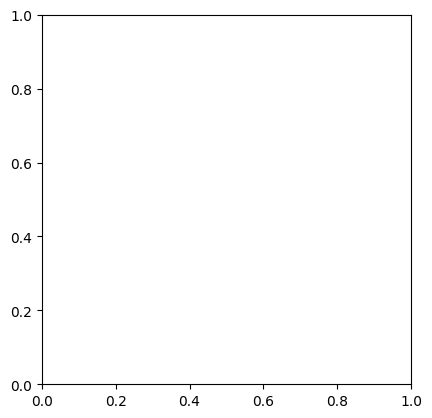

In [34]:
plt.imshow(i.flatten())

In [394]:
import pickle
import pickle

with open('outfile_cart150', 'wb') as fp:
    pickle.dump(x_train_cart, fp)
# with open('outfile_test300', 'wb') as fp:
#     pickle.dump(y_train, fp)

In [154]:
train = np.array(x_train_cop)
X_train = train.reshape(2816, 150*150)
X_train.shape

(2816, 22500)

In [159]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D
from keras.utils import np_utils



In [397]:
model = Sequential()
# hidden layer
model.add(Dense(25, input_shape=(25,), activation='relu'))
# output layer
model.add(Dense(25, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='softmax'))

# looking at the model summary
model.summary()
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
# # training the model for 10 epochs
model.fit(np.array(x_train), np.array(nk), epochs=10)

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_92 (Dense)            (None, 25)                650       
                                                                 
 dense_93 (Dense)            (None, 25)                650       
                                                                 
 dense_94 (Dense)            (None, 20)                520       
                                                                 
 dense_95 (Dense)            (None, 10)                210       
                                                                 
 dense_96 (Dense)            (None, 1)                 11        
                                                                 
Total params: 2,041
Trainable params: 2,041
Non-trainable params: 0
_________________________________________________________________


ValueError: Data cardinality is ambiguous:
  x sizes: 600
  y sizes: 2816
Make sure all arrays contain the same number of samples.

In [ ]:
with open ('x_train_cart', 'rb') as fp:
    itemlists = pickle.load(fp)
itemlists

In [290]:
import sys
np.set_printoptions(threshold=sys.maxsize)
model.predict(np.array(x_train))

88/88 [==============================] - 0s 2ms/step


array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [284]:
np.array(x_train)[0:7]

array([[3.18309886e-01, 3.97035708e-16, 1.44372034e-01, 3.85464600e-02,
        3.86891056e-02, 1.32152041e-02, 1.06979123e-01, 3.37935074e-02,
        4.23788050e-02, 1.09729294e-01, 3.29883382e-02, 5.13545180e-03,
        2.30459874e-01, 8.01084731e-02, 3.17334666e-02, 1.41435407e-02,
        8.39124204e-02, 3.95685701e-02, 1.69138499e-02, 8.24346747e-03,
        4.52523498e-02, 6.34053394e-02, 2.89167621e-02, 1.94750021e-02,
        2.48882117e-02],
       [3.18309886e-01, 3.72320385e-16, 2.00048544e-01, 4.04076965e-02,
        3.53077534e-02, 3.73002388e-03, 1.68388021e-02, 3.23873102e-02,
        4.95763177e-02, 5.16621185e-02, 2.60352719e-02, 3.91219058e-03,
        3.51597837e-01, 4.79497844e-02, 2.13309290e-02, 3.67151263e-03,
        3.72015253e-02, 1.91703244e-02, 1.88910175e-02, 3.48670230e-03,
        1.73165019e-01, 6.06048017e-02, 3.66698910e-02, 3.91268064e-03,
        2.28731438e-02],
       [3.18309886e-01, 5.19521435e-16, 9.99555355e-02, 2.33848220e-02,
        9.3012

In [286]:
np.array(nk)[0]

1

In [220]:
np.array(nk).shape

(2816,)

In [186]:
tt = train.reshape(len(train), 150*150)
tt.shape

(2816, 22500)

In [185]:
len(train)

2816

In [133]:
y_train_cop = y_train

In [134]:
nk = []
for i in y_train:
    nk.append(i)
    nk.append(i)
    nk.append(i)
    nk.append(i)
print(len(nk))
nk

2816


[1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [146]:
x_train_cop
import pickle
import pickle

with open('y_train_full_nor', 'wb') as fp:
    pickle.dump(nk, fp)

In [252]:
np.array(x_train).shape

(2816, 25)

In [232]:
x_train_nor

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],


In [257]:
np.array(x_train)

(2816, 25)

In [263]:
with open('y_train_nor', 'wb') as fp:
    pickle.dump(nk, fp)

In [262]:
len(nk)

2816

In [265]:
np.array(nk).shape[0]

2816

In [267]:
np.array(x_train_cop).shape

(2816, 150, 150)

In [269]:
tt.shape

(2816, 22500)

In [275]:
from PIL import Image
im = Image.open('L3.JPG', 'r')
im
np.array(im)

array([[[194, 132,  59],
        [195, 133,  60],
        [197, 135,  62],
        ...,
        [ 24,  19,  13],
        [ 23,  18,  12],
        [ 23,  18,  12]],

       [[193, 131,  58],
        [194, 132,  59],
        [195, 132,  61],
        ...,
        [ 24,  19,  13],
        [ 26,  19,  13],
        [ 25,  18,  12]],

       [[193, 130,  59],
        [193, 130,  59],
        [194, 131,  60],
        ...,
        [ 24,  19,  13],
        [ 26,  19,  13],
        [ 26,  19,  13]],

       ...,

       [[139,  82,  37],
        [140,  83,  38],
        [141,  82,  38],
        ...,
        [ 24,  19,  13],
        [ 23,  20,  13],
        [ 23,  20,  13]],

       [[140,  81,  37],
        [141,  82,  38],
        [141,  82,  38],
        ...,
        [ 24,  21,  14],
        [ 24,  21,  14],
        [ 24,  21,  14]],

       [[140,  81,  37],
        [140,  81,  37],
        [143,  82,  38],
        ...,
        [ 24,  21,  14],
        [ 22,  22,  14],
        [ 22,  22,  14]]

In [276]:
src = cv2.imread(img, cv2.IMREAD_UNCHANGED)
src
new_size = (150, 150) 
resize_img = cv2.resize(src, new_size)
gray_img = cv2.cvtColor(resize_img, cv2.COLOR_BGR2GRAY)
gray_img

array([[  3,   4,   4, ..., 223, 219, 218],
       [  4,   5,   5, ..., 221, 220, 220],
       [  4,   4,   5, ..., 224, 219, 219],
       ...,
       [  6,   6,   5, ..., 211, 214, 214],
       [  7,   6,   5, ..., 215, 213, 213],
       [  6,   6,   5, ..., 216, 215, 216]], dtype=uint8)

In [329]:
import sys
import cv2
import numpy as np
from scipy.interpolate import interp1d
from PIL import Image



original_eye = np.asarray()
eye_image = cv2.cvtColor(original_eye, cv2.COLOR_RGB2GRAY)


eye_circles = cv2.HoughCircles(eye_image, cv2.HOUGH_GRADIENT, 2, 100,  minRadius = 90, maxRadius = 200)
print(eye_circles)
if eye_circles is not None:
    circle = eye_circles[0][0]
    iris_coordinates = (circle[0], circle[1])
    print("iris cordinates", iris_coordinates)

if iris_coordinates is not None:
    x = int(iris_coordinates[0])
    y = int(iris_coordinates[1])

    w = int(round(circle[2]) + 10)
    h = int(round(circle[2]) + 10)
    print(w,h)

    #cv2.circle(original_eye, iris_coordinates, int(circle[2]), (255,0,0), thickness=2)
    iris_image = original_eye[y-h:y+h,x-w:x+w]
    iris_image_to_show = cv2.resize(iris_image, (iris_image.shape[1]*2, iris_image.shape[0]*2))

q = np.arange(0.00, np.pi*2, 0.01) #theta
inn = np.arange(0, int(iris_image_to_show.shape[0]/2), 1) #radius

cartisian_image = np.empty(shape = [inn.size, int(iris_image_to_show.shape[1]), 3])
m = interp1d([np.pi*2, 0],[0,iris_image_to_show.shape[1]])

for r in inn:
    for t in q:
        polarX = int((r * np.cos(t)) + iris_image_to_show.shape[1]/2)
        polarY = int((r * np.sin(t)) + iris_image_to_show.shape[0]/2)
        cartisian_image[r][int(m(t) - 1)] = iris_image_to_show[polarY][polarX]

im = Image.fromarray(iris_image_to_show)
im.save('eye.jpeg')
cartisian_image = cartisian_image.astype('uint8')
im = Image.fromarray(cartisian_image)
im.save('cartesian_eye.jpeg')

[[[2173.  2247.   198.8]
  [2041.  2301.   198.8]
  [2219.  2339.   194.4]
  [2313.  2303.   198.8]
  [2433.  2305.   198.8]
  [2623.  1005.   194.4]
  [2321.  2161.   139.4]
  [2397.  1297.   192.2]
  [2095.  2387.   159.2]
  [2945.   721.   198.8]
  [2295.  2045.   198.8]
  [2767.   873.   152.6]
  [2473.  1227.   194.4]
  [2237.  2443.   185.6]
  [2831.   727.   185.6]
  [2431.  2113.   132.8]
  [1983.  2209.   179. ]
  [2521.  1073.   185.6]
  [2315.  1375.   198.8]
  [2641.  1167.   194.4]
  [2317.  2581.   163.6]
  [2167.  2145.   152.6]
  [2897.  1049.   192.2]
  [2637.   857.   190. ]
  [2143.  2507.   179. ]
  [2529.  2135.   137.2]
  [2353.   941.   185.6]
  [2867.   925.   150.4]
  [2397.  2403.   185.6]
  [3009.   989.   183.4]
  [2579.  1307.   161.4]
  [3073.   851.   141.6]
  [1979.  1577.   148.2]
  [2359.  1143.   130.6]
  [2227.   933.   190. ]
  [2727.  1087.   139.4]
  [2499.  1383.   181.2]
  [2217.  1431.   174.6]
  [1975.  2423.   104.2]
  [2089.  1147.   194.4]


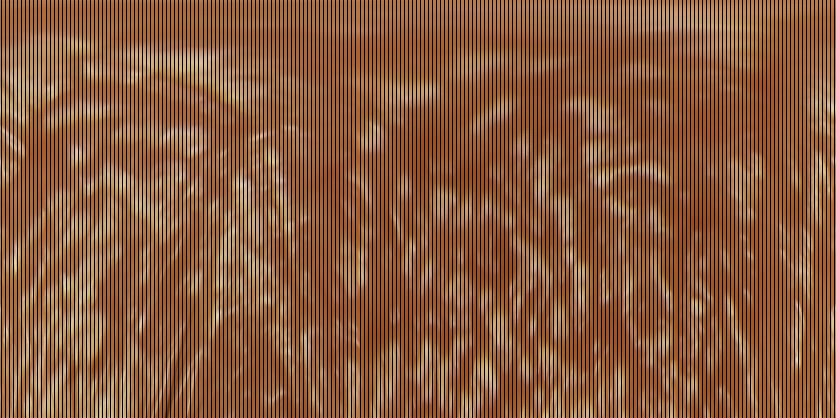

In [301]:
im

In [ ]:
iris_image_to_show

(150, 150)
75


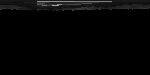

In [368]:
q = np.arange(0.00, np.pi*2, 0.01) #theta
iris_image_to_show = cv2.imread("maskimg.jpg", cv2.IMREAD_UNCHANGED)
print(iris_image_to_show.shape)
inn = np.arange(0, int(iris_image_to_show.shape[0]/2), 1) #radius
print(inn.size)
cartisian_image = np.empty(shape = [inn.size, int(iris_image_to_show.shape[1]), 3])
m = interp1d([np.pi*2, 0],[0,iris_image_to_show.shape[1]])

for r in inn:
    for t in q:
        polarX = int((r * np.cos(t)) + iris_image_to_show.shape[1]/2)
        polarY = int((r * np.sin(t)) + iris_image_to_show.shape[0]/2)
        cartisian_image[r][int(m(t) - 1)] = iris_image_to_show[polarY][polarX]

im = Image.fromarray(iris_image_to_show)
im.save('eye.jpeg')
cartisian_image = cartisian_image.astype('uint8')
im = Image.fromarray(cartisian_image)
im.save('cartesian_eye.jpeg')
im

In [374]:

np.array(im)

array([[[ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25],


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import mahotas.features
import itertools
import math
from typing import Tuple, List
from PIL import Image
import os
from scipy.interpolate import interp1d
from scipy.signal import convolve
def daugman(gray_img: np.ndarray, center: Tuple[int, int],
                start_r: int, end_r: int, step: int = 1) -> Tuple[float, int]:
        """ The function will calculate pixel intensities for the circles
            in the ``range(start_r, end_r, step)`` for a given ``center``,
            and find a circle that precedes the biggest intensity drop
            :param gray_img: grayscale picture
            :param center:  center coordinates ``(x, y)``
            :param start_r: bottom value for iris radius in pixels
            :param end_r: top value for iris radius in pixels
            :param step: step value for iris radii range in pixels
            .. attention::
                Input grayscale image should be a square, not a rectangle
            :return: intensity_value, radius
        """
        x, y = center
        intensities = []
        mask = np.zeros_like(gray_img)

        radii = list(range(start_r, end_r, step))  # type: List[int]
        for r in radii:

            cv2.circle(mask, center, r, 255, 1)

            diff = gray_img & mask

            intensities.append(np.add.reduce(diff[diff > 0]) / (2 * math.pi * r))

            mask.fill(0)


        intensities_np = np.array(intensities, dtype=np.float32)
        del intensities

        intensities_np = intensities_np[:-1] - intensities_np[1:]

        intensities_np = abs(cv2.GaussianBlur(intensities_np, (1, 5), 0))

        idx = np.argmax(intensities_np) 

        return intensities_np[idx], radii[idx]


def find_iris(gray: np.ndarray, *,
              daugman_start: int, daugman_end: int,
              daugman_step: int = 1, points_step: int = 1,) -> Tuple[Tuple[int, int], int]:
    """ The function will apply :func:`daugman` on every pixel in the calculated image slice.
        Basically, we are calculating where lies set of valid circle centers.
        It is assumed that iris center lies within central 1/3 of the image.
        :param gray: graysacale **square** image
        :param points_step: it will run daugman for each ``points_step``th point.
                            It has linear correlation with overall iris search speed
        :param daugman_start: bottom value for iris radius in pixels for :func:``daugman``
        :param daugman_end: top value for iris radius in pixels for :func:``daugman``
        :param daugman_step: step value for iris radii range in pixels for :func:``daugman``.
                             It has linear correlation with overall iris search speed
        :return: radius with biggest intensiveness delta on image as ``((xc, yc), radius)``
    """
    h, w = gray.shape
    if h != w:
        print('Your image is not a square!')
    print("yes")
    single_axis_range = range(int(h / 3), h - int(h / 3), points_step)
    all_points = itertools.product(single_axis_range, single_axis_range)
    intensity_values = []
    coords = []  
    for point in all_points:
        val, r = daugman(gray, point, daugman_start, daugman_end, daugman_step)
        intensity_values.append(val)
        coords.append((point, r))
    best_idx = intensity_values.index(max(intensity_values))
    return coords[best_idx]

# def detect_iris(image_path : str,output_save_path : str):
#     '''
#     The function detects the iris part of the human eye and return the iris image as rectangular format.
#     :param image_path: path of the input image file
#     :param output_save_path:  output path to save iris image
#     '''
#     image = Image.open(image_path)
#     color_coverted = cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2GRAY)
#     new_size = (200, 200) 
#     res = cv2.resize(np.asarray(image), new_size)
#     resize_img = cv2.resize(color_coverted, new_size)
#     gray_img = resize_img
#     answer = find_iris(gray_img, daugman_start=9, daugman_end=30, daugman_step=4, points_step=4)
#     #print(answer)
#     answer_1 = find_iris(gray_img, daugman_start=10, daugman_end=30, daugman_step=1, points_step=1)
#     iris_center, iris_rad = answer
#     iris_center_1, iris_rad_1 = answer_1
#     ### to see only iris use this code
#     # for i in range(res.shape[0]):
#     #     for j in range(res.shape[0]):
#     #         if ((i-iris_center_1[1])**2+(j-iris_center_1[0])**2-(iris_rad-1)**2<0) or ((i-iris_center_1[1])**2+(j-iris_center_1[0])**2-iris_rad_1**2>0):
#     #             res[i][j] = [255,255,255]
#     # plt.imsave('output.jpg',res)
#     size = (min(image.size),min(image.size))
#     hig_res = cv2.resize(np.asarray(image), size)
#     multiplier = size[0]/res.shape[0]
#     iris_center_norm = tuple(int(multiplier*elem) for elem in iris_center_1)
#     warped = cv2.warpPolar(hig_res, (size[0], int(size[0] * math.pi)), iris_center_norm, iris_rad_1*multiplier, 0)
#     straightened = cv2.rotate(warped, cv2.ROTATE_90_COUNTERCLOCKWISE)
#     cropped = straightened[: int(straightened.shape[0] * (1 - iris_rad/iris_rad_1)), :]
#     #plt.imsave(output_save_path, cropped)
    

In [6]:
import fnmatch
image_path = "R3.JPG"
output_save_path = "output_normalised.png"
root = 'D:\\5505\\5505\\train_images_301-450'
pattern = ".JPG"
final_img_li = []
final_zer_li = []
for path, subdirs, files in os.walk(root):
    files1=0
    for name in files:
        
        print(path)
        
        if fnmatch.fnmatch(name, pattern):
            print(os.path.join(path, name))
        img = os.path.join(path, name)
        image = Image.open(img)
        color_coverted = cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2GRAY)
        new_size = (200, 200) 
        res = cv2.resize(np.asarray(image), new_size, interpolation = cv2.INTER_LINEAR)
        resize_img = cv2.resize(color_coverted, new_size)
        gray_img = resize_img
        answer = find_iris(gray_img, daugman_start=9, daugman_end=30, daugman_step=4, points_step=4)
        #print(answer)
        answer_1 = find_iris(gray_img, daugman_start=10, daugman_end=30, daugman_step=1, points_step=1)
        iris_center, iris_rad = answer
        iris_center_1, iris_rad_1 = answer_1
        if iris_rad == iris_rad_1:
            iris_rad_1 +=1
            print(iris_rad, iris_rad_1)
        ### to see only iris use this code
        # for i in range(res.shape[0]):
        #     for j in range(res.shape[0]):
        #         if ((i-iris_center_1[1])**2+(j-iris_center_1[0])**2-(iris_rad-1)**2<0) or ((i-iris_center_1[1])**2+(j-iris_center_1[0])**2-iris_rad_1**2>0):
        #             res[i][j] = [255,255,255]
        # plt.imsave('output.jpg',res)
        size = (min(image.size),min(image.size))
        hig_res = cv2.resize(np.asarray(image), size)
        multiplier = size[0]/res.shape[0]
        iris_center_norm = tuple(int(multiplier*elem) for elem in iris_center_1)
        warped = cv2.warpPolar(hig_res, (size[0], int(size[0] * math.pi)), iris_center_norm, iris_rad_1*multiplier, 0)
        straightened = cv2.rotate(warped, cv2.ROTATE_90_COUNTERCLOCKWISE)
        cropped = straightened[: int(straightened.shape[0] * (1 - iris_rad/iris_rad_1)), :]
        iris_img = cv2.circle(res, iris_center, iris_rad, (255, 0, 0), 1)
        
        #iris_img = cv2.circle(res, (int(coordPupil[0][0]), int(coordPupil[1])), int(10), (255, 0, 0), 1)
        # iris_img = cv2.circle(out, iris_center, iris_rad,coord (0, 0, 255), 1)
#         _ = plt.imshow(res[::,::])
        iris_img = cv2.circle(gray_img, iris_center_1, iris_rad_1, (255, 0, 0), 1)
       # _ = plt.imshow(gray_img[::,::])
        #plt.show()
        #plt.imshow(cropped)
        
#         plt.imsave(output_save_path, cropped)
        gray_crop_img = cv2.cvtColor(np.asarray(cropped), cv2.COLOR_RGB2GRAY)
#         plt.imshow(cropped)
#         plt.show()
       # zer_mom_norm = mahotas.features.zernike_moments(gray_crop_img, 10)
        final_zer_li.append(zer_mom_norm)
        final_img_li.append(gray_crop_img)
        

D:\5505\5505\train_images_301-450\301
yes
yes
D:\5505\5505\train_images_301-450\301
yes
yes
D:\5505\5505\train_images_301-450\301
yes
yes
D:\5505\5505\train_images_301-450\301
yes
yes
D:\5505\5505\train_images_301-450\302
yes
yes
D:\5505\5505\train_images_301-450\302
yes
yes
D:\5505\5505\train_images_301-450\302
yes
yes
D:\5505\5505\train_images_301-450\302
yes
yes
D:\5505\5505\train_images_301-450\303
yes
yes
D:\5505\5505\train_images_301-450\303
yes
yes
D:\5505\5505\train_images_301-450\303
yes
yes
D:\5505\5505\train_images_301-450\303
yes
yes
D:\5505\5505\train_images_301-450\304
yes
yes
D:\5505\5505\train_images_301-450\304
yes
yes
D:\5505\5505\train_images_301-450\304
yes
yes
D:\5505\5505\train_images_301-450\304
yes
yes
D:\5505\5505\train_images_301-450\305
yes
yes
D:\5505\5505\train_images_301-450\305
yes
yes
D:\5505\5505\train_images_301-450\305
yes
yes
D:\5505\5505\train_images_301-450\305
yes
yes
D:\5505\5505\train_images_301-450\306
yes
yes
D:\5505\5505\train_images_301-450\

D:\5505\5505\train_images_301-450\345
yes
yes
D:\5505\5505\train_images_301-450\345
yes
yes
D:\5505\5505\train_images_301-450\346
yes
yes
D:\5505\5505\train_images_301-450\346
yes
yes
D:\5505\5505\train_images_301-450\346
yes
yes
D:\5505\5505\train_images_301-450\346
yes
yes
D:\5505\5505\train_images_301-450\347
yes
yes
D:\5505\5505\train_images_301-450\347
yes
yes
D:\5505\5505\train_images_301-450\347
yes
yes
D:\5505\5505\train_images_301-450\347
yes
yes
D:\5505\5505\train_images_301-450\348
yes
yes
D:\5505\5505\train_images_301-450\348
yes
yes
D:\5505\5505\train_images_301-450\348
yes
yes
D:\5505\5505\train_images_301-450\348
yes
yes
D:\5505\5505\train_images_301-450\349
yes
yes
D:\5505\5505\train_images_301-450\349
yes
yes
D:\5505\5505\train_images_301-450\349
yes
yes
D:\5505\5505\train_images_301-450\349
yes
yes
D:\5505\5505\train_images_301-450\350
yes
yes
D:\5505\5505\train_images_301-450\350
yes
yes
D:\5505\5505\train_images_301-450\350
yes
yes
D:\5505\5505\train_images_301-450\

KeyboardInterrupt: 